#### In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
#from grids import *
from docking_analysis import *
import sklearn

/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
from msm_resampled import *

In [3]:
%matplotlib inline

In [4]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [5]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [6]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.01
rho_string = "_rho0pt01-normalized"

feature_name = "bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF"

#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=50
n_clusters=1000
n_components=10

In [7]:
feature_name

'bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF'

In [8]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
tica_dir = "%s-aromatic-binarize-py3" %tica_dir

ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF


In [9]:
all_ligand_features_dir = "%s-with-aromatic" %features_dir
if not os.path.exists(all_ligand_features_dir): os.makedirs(all_ligand_features_dir)

In [10]:
ligand_residue = Residue(resSeq=1, chain_id="O", res_name="LIG")

In [11]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "suf" in t.lower()][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name]
print(ligand_atom_names)

['C13', 'C17', 'C18', 'C19', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'S1', 'O2', 'O3', 'N4', 'N5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'C15', 'C16', 'C20', 'C21']


In [12]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=1, chain_id="O", atom_name=atom_name, res_name="LIG"))

In [13]:
user_specified_atom_residue_pairs = sorted([x for x in itertools.product(ligand_atoms, bp_residue_objects)])
user_specified_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in user_specified_atom_residue_pairs]

In [14]:
len(user_specified_atom_residue_pairs)

2565

In [15]:
from imp import reload
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
protein_file = "/home/enf/md_simulations/MOR/suf_ref.h5"
refined_atom_residue_pairs = sorted(compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True))

In [16]:
refined_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in refined_atom_residue_pairs]
print(len(refined_atom_residue_pairs))


811


In [158]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

351


<AsyncMapResult: chdir>

In [18]:
print(len(rc.ids))

351


In [19]:
aromatic_features_dir = "%s/suf_aromatic_features" %traj_dir
if not os.path.exists(aromatic_features_dir):
    os.makedirs(aromatic_features_dir)
aromatic_features_file = "%s/aromatic_features.dataset" %aromatic_features_dir
ring_dict = {}
suf_ring_dict = {}
suf_ring_dict["suf_ring1"] = [Atom(atom_name=n, res_name="LIG") for n in ["C22", "C17", "C13", "C18", "C23", "C25"]]
suf_ring_dict["suf_ring2"] = [Atom(atom_name=n, res_name="LIG") for n in ["C19", "S1", "C27", "C26", "C24"]]
ring_dict["tyr326_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=326) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr148_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=148) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr128_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=128) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["phe289_ring"] = [Atom(atom_name=n, res_name="PHE", resSeq=289) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["trp293_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp293_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp133_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp133_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp318_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp318_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["his297_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=297) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]
ring_dict["his319_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=319) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]

cation = Atom(atom_name="N4", res_name="LIG")

In [20]:
suf_ring_dict

{'suf_ring1': [LIG-C22, LIG-C17, LIG-C13, LIG-C18, LIG-C23, LIG-C25],
 'suf_ring2': [LIG-C19, LIG-S1, LIG-C27, LIG-C26, LIG-C24]}

In [21]:

pi_pi_ring_pairs = [(ring_dict["trp293_ring1"], ring_dict["phe289_ring"]), (ring_dict["trp293_ring2"], ring_dict["phe289_ring"])]
#ring_pairs = []
for i, ring_i in enumerate(suf_ring_dict.values()):
    for j, ring_j in enumerate(ring_dict.values()):
        pi_pi_ring_pairs.append((ring_i, ring_j))
cation_pi_pairs = [(cation, ring) for ring in ring_dict.values()]

In [33]:
suf_traj_files = [t for t in get_trajectory_files(traj_dir, traj_ext) if "suf" in t]

compute_aromatic_features_wrapper(traj_dir, traj_ext, None, pi_pi_ring_pairs, cation_pi_pairs,
    aromatic_features_file, aromatic_features_dir, worker_pool=dview, 
    parallel=False, traj_files=suf_traj_files)


NameError: name 'dview' is not defined

In [22]:
aromatic_feature_objects = get_aromatic_feature_names(pi_pi_ring_pairs, cation_pi_pairs)
aromatic_names = [str(a) for a in aromatic_feature_objects]
aromatic_names

['TRP293-CD2 to PHE289-CG: Pi Parallel',
 'TRP293-CG to PHE289-CG: Pi Parallel',
 'LIG-C22 to TRP318-CG: Pi Parallel',
 'LIG-C22 to TYR148-CG: Pi Parallel',
 'LIG-C22 to TYR128-CG: Pi Parallel',
 'LIG-C22 to TRP318-CD2: Pi Parallel',
 'LIG-C22 to HIS297-ND1: Pi Parallel',
 'LIG-C22 to TRP133-CG: Pi Parallel',
 'LIG-C22 to TRP133-CD2: Pi Parallel',
 'LIG-C22 to TRP293-CG: Pi Parallel',
 'LIG-C22 to TYR326-CG: Pi Parallel',
 'LIG-C22 to PHE289-CG: Pi Parallel',
 'LIG-C22 to TRP293-CD2: Pi Parallel',
 'LIG-C22 to HIS319-ND1: Pi Parallel',
 'LIG-C19 to TRP318-CG: Pi Parallel',
 'LIG-C19 to TYR148-CG: Pi Parallel',
 'LIG-C19 to TYR128-CG: Pi Parallel',
 'LIG-C19 to TRP318-CD2: Pi Parallel',
 'LIG-C19 to HIS297-ND1: Pi Parallel',
 'LIG-C19 to TRP133-CG: Pi Parallel',
 'LIG-C19 to TRP133-CD2: Pi Parallel',
 'LIG-C19 to TRP293-CG: Pi Parallel',
 'LIG-C19 to TYR326-CG: Pi Parallel',
 'LIG-C19 to PHE289-CG: Pi Parallel',
 'LIG-C19 to TRP293-CD2: Pi Parallel',
 'LIG-C19 to HIS319-ND1: Pi Parallel

In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
import time
#time.sleep(60*120)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel=True , exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=user_specified_atom_residue_pairs, worker_pool=None, excluded_trajs=["apo", "oxy", "suf"], redo=True, binarize=None)

In [23]:
ori_feature_names = compat_verboseload(feature_residues_pkl)

In [24]:
from imp import reload
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
#retain_features_within_range(features_dir, ori_feature_names, 0.5,
#                             0.01, new_features_file, new_features_pkl, worker_pool=None)

In [25]:
new_feature_names = compat_verboseload(new_features_pkl)
feature_residues = new_feature_names
print(new_feature_names)
print(len(new_feature_names))

[Lig1-C10 to Asp147, Lig1-C10 to Gln124, Lig1-C10 to Ile144, Lig1-C10 to Ile322, Lig1-C10 to Lys233, Lig1-C10 to Lys303, Lig1-C10 to Trp318, Lig1-C10 to Tyr148, Lig1-C10 to Tyr299, Lig1-C10 to Val300, Lig1-C11 to Cys321, Lig1-C11 to Gln124, Lig1-C11 to Gly325, Lig1-C11 to Ile296, Lig1-C11 to Ile322, Lig1-C11 to Lys233, Lig1-C11 to Trp293, Lig1-C11 to Trp318, Lig1-C11 to Tyr148, Lig1-C11 to Tyr299, Lig1-C11 to Tyr326, Lig1-C11 to Val300, Lig1-C12 to Asp147, Lig1-C12 to Gln124, Lig1-C12 to Ile144, Lig1-C12 to Ile322, Lig1-C12 to Thr120, Lig1-C12 to Trp133, Lig1-C12 to Trp318, Lig1-C12 to Tyr128, Lig1-C12 to Tyr148, Lig1-C12 to Tyr326, Lig1-C12 to Val143, Lig1-C13 to Ala117, Lig1-C13 to Asp147, Lig1-C13 to Gly325, Lig1-C13 to His297, Lig1-C13 to Ile296, Lig1-C13 to Ile322, Lig1-C13 to Met151, Lig1-C13 to Trp293, Lig1-C13 to Tyr148, Lig1-C13 to Tyr326, Lig1-C13 to Val236, Lig1-C13 to Val300, Lig1-C14 to Asp147, Lig1-C14 to Gly325, Lig1-C14 to His297, Lig1-C14 to Ile296, Lig1-C14 to Ile322,

In [26]:
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)
all_ligand_features_pkl = "%s/feature_names.pkl" %all_ligand_features_dir
all_ligand_feature_names = feature_residues + aromatic_names #[n for n in aromatic_names if "lig" in str(n).lower()]
all_ligand_feature_objects = feature_residues + aromatic_feature_objects #[n for n in aromatic_feature_objects if "lig" in str(n).lower()]
with open(all_ligand_features_pkl, "wb") as f:
    pickle.dump(all_ligand_feature_objects, f)
print(all_ligand_feature_objects)

[Lig1-C10 to Asp147, Lig1-C10 to Gln124, Lig1-C10 to Ile144, Lig1-C10 to Ile322, Lig1-C10 to Lys233, Lig1-C10 to Lys303, Lig1-C10 to Trp318, Lig1-C10 to Tyr148, Lig1-C10 to Tyr299, Lig1-C10 to Val300, Lig1-C11 to Cys321, Lig1-C11 to Gln124, Lig1-C11 to Gly325, Lig1-C11 to Ile296, Lig1-C11 to Ile322, Lig1-C11 to Lys233, Lig1-C11 to Trp293, Lig1-C11 to Trp318, Lig1-C11 to Tyr148, Lig1-C11 to Tyr299, Lig1-C11 to Tyr326, Lig1-C11 to Val300, Lig1-C12 to Asp147, Lig1-C12 to Gln124, Lig1-C12 to Ile144, Lig1-C12 to Ile322, Lig1-C12 to Thr120, Lig1-C12 to Trp133, Lig1-C12 to Trp318, Lig1-C12 to Tyr128, Lig1-C12 to Tyr148, Lig1-C12 to Tyr326, Lig1-C12 to Val143, Lig1-C13 to Ala117, Lig1-C13 to Asp147, Lig1-C13 to Gly325, Lig1-C13 to His297, Lig1-C13 to Ile296, Lig1-C13 to Ile322, Lig1-C13 to Met151, Lig1-C13 to Trp293, Lig1-C13 to Tyr148, Lig1-C13 to Tyr326, Lig1-C13 to Val236, Lig1-C13 to Val300, Lig1-C14 to Asp147, Lig1-C14 to Gly325, Lig1-C14 to His297, Lig1-C14 to Ile296, Lig1-C14 to Ile322,

In [27]:
all_contact_features = load_file(new_features_file)
all_contact_features = [sklearn.preprocessing.binarize(f, 0.5) for f in all_contact_features]
aromatic_features = load_file(aromatic_features_file)
indices = [i for i in range(0,len(aromatic_names)) if "lig" in str(aromatic_names[i]).lower()]
print(indices)
#all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i][:,indices]]) for i in range(0,len(all_contact_features))]
all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i]]) for i in range(0,len(all_contact_features))]

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/suf_aromatic_features/aromatic_features.dataset
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [ ]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
import custom_tica
reload(custom_tica)
from custom_tica import *
#fit_normalizer(features_dir, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=False, partial_fit=False, features=all_ligand_features)

In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
if not os.path.exists(ref_features_dir):
    os.makedirs(ref_features_dir)
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=verboseload("%s/normalizer.h5" %features_dir))

In [28]:
tica_object = compat_verboseload(projection_operator_dir)
tica_object.timescales_

array([ 515.93989827,  327.58078377,  276.47562054,  233.589608  ,
        210.46394913,  198.78522811,  171.47962917,  162.91166301,
        154.21311352,  144.13468294])

In [29]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
#important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, all_ligand_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(21, 5)
residue_importances_df.shape
(25, 2)
                    feature_name      res_i      res_j  importance  \
3             Lig1-C20 To Trp293   Lig1-C20     Trp293   -0.707351   
18             Lig1-O3 To Tyr299    Lig1-O3     Tyr299    0.407946   
1             Lig1-C20 To Cys321   Lig1-C20     Cys321    0.397416   
5             Lig1-C20 To Tyr299   Lig1-C20     Tyr299    0.364832   
15             Lig1-C8 To Val300    Lig1-C8     Val300    0.334571   
17             Lig1-O2 To Tyr299    Lig1-O2     Tyr299    0.325392   
6             Lig1-C22 To Ile322   Lig1-C22     Ile322   -0.277202   
16             Lig1-C9 To Ala117    Lig1-C9     Ala117    0.275897   
14             Lig1-C7 To Thr120    Lig1-C7     Thr120    0.243362   
7             Lig1-C22 To Ser329   Lig1-C22     Ser329    0.240427   
4             Lig1-C20 To Trp318   Lig1-C20     Trp318   -0.216052   
11            Lig1-C25 To Asp114   Lig1-C25     Asp114    0.206774 

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/interpret_tICs.py:97: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


             residue  importance
Tyr299        Tyr299    0.403634
Cys321        Cys321    0.397416
Lig1-O3      Lig1-O3    0.395715
Lig1-C20    Lig1-C20    0.390899
Lig1-C8      Lig1-C8    0.334571
Val300        Val300    0.326009
Lig1-O2      Lig1-O2    0.325392
Ile322        Ile322   -0.277202
Lig1-C9      Lig1-C9    0.275897
Ala117        Ala117    0.270179
Thr120        Thr120    0.243362
Lig1-C7      Lig1-C7    0.243362
Ser329        Ser329    0.240427
Trp318        Trp318   -0.216052
Asp114        Asp114    0.206774
Lig1-C22    Lig1-C22    0.200865
Lig1-C11    Lig1-C11    0.194875
Gly325        Gly325    0.194299
Trp293        Trp293   -0.174708
Lig1-C25    Lig1-C25    0.171429
Asn150        Asn150    0.161553
Lig1-C23    Lig1-C23    0.161551
Tyr326        Tyr326   -0.156742
Trp293-Cg  Trp293-Cg    0.096202
Phe289-Cg  Phe289-Cg    0.096202
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(22, 5)
residue_importances_df.shape
(26, 2)
                          f

In [30]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [69]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

print(tic_subsampled_features_file)
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/features_subsampled.pkl


TypeError: 'AromaticFeature' object is not iterable

In [31]:
tica_coords = compat_verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

(272021, 10)


In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["suf_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [32]:
suf_trajs = []
apo_trajs = []
suf_trajs = []

suf_reseeded_trajs = []
suf_ori_trajs = []
apo_reseeded_trajs = []
apo_ori_trajs = []
suf_ori_trajs = []
suf_reseeded_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "suf" in traj:
        suf_trajs.append(i)
        if "reseeded" in traj:
            suf_reseeded_trajs.append(i)
        else:
            suf_ori_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)
        if "reseeded" in traj:
            apo_reseeded_trajs.append(i)
        else:
            apo_ori_trajs.append(i)
    elif "suf" in traj:
        suf_trajs.append(i)
        if "reseeded" in traj:
            suf_reseeded_trajs.append(i)
        else:
            suf_ori_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5


In [33]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup"

In [34]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = compat_verboseload(protein_tica_file)
protein_tica_suf = compat_verboseload("%s/suf_tica.h5" %pp_tica_dir)

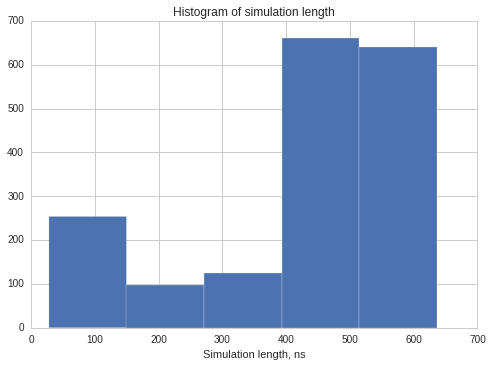

In [35]:
plt.clf()
plt.hist([t.shape[0] for t in protein_tica], bins=5)
plt.xlabel("Simulation length, ns")
plt.title("Histogram of simulation length")
hist_fig_file = "%s/simulation_length_histogram.png" %traj_dir
plt.savefig(hist_fig_file)

In [36]:
len(protein_tica)

1778

In [37]:
print(np.sum([protein_tica[i].shape[0] for i in suf_ori_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in apo_ori_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in suf_ori_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in suf_reseeded_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in apo_reseeded_trajs]))
print(np.sum([protein_tica[i].shape[0] for i in suf_reseeded_trajs]))
print(np.sum([t.shape[0] for t in protein_tica]))


105298
115839
105298
166723
119620
166723
755979


In [38]:
protein_tica_suf_conc = np.concatenate(protein_tica_suf)
ligand_tica_suf_conc =  np.concatenate(compat_verboseload(projected_features_dir))

In [ ]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_suf_conc, ligand_tica_suf_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["suf_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
n_clusters = 1000
clusterer_dir = "%s/sufclusterer_%dclusters.h5" % (tica_dir, n_clusters)
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir)

In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

In [ ]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)
suf_msm = compat_verboseload(msm_model_dir)

In [ ]:
'%s/suf_clusterer1000.h5' %pp_tica_dir

In [39]:
pp_msm_lag_time=25
pp_n_clusters = 1000
prior_counts=1e-5
suf_pp_resampled_traj_to_frames_file = "%s/suf_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
suf_pp_resampled_traj_to_frames = verboseload(suf_pp_resampled_traj_to_frames_file)
suf_pp_msm_file = "%s/suf_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
suf_pp_msm = verboseload(suf_pp_msm_file)
suf_pp_clusterer = verboseload('%s/suf_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
suf_pp_clusters_map = make_clusters_map(suf_pp_clusterer)
suf_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
suf_pp_clusterer_file = '%s/suf_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters)

suf_pp_tic_components_dir = "%s" %pp_tica_dir
suf_pp_tica_dir = suf_pp_tic_components_dir
suf_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl"
pp_tic_subsampled_features = '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl'
#pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
suf_pp_tica = verboseload("%s/suf_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters))
suf_pp_pnas_file = "%s/suf_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
suf_pp_pnas = verboseload(suf_pp_pnas_file)
suf_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000.h5"...
517
31
267
95
508
0
7
1167
0
651
1
20
0
11
1516
0
909
33
144
1490
277
2
0
559
5
1171
183
37
1334
742
45
11
1047
605
0
19
51
3
0
10
83
538
188
181
1335
4
283
951
0
0
1024
0
257
40
29
337
4
1394
0
131
143
0
324
120
108
43
177
1
480
974
703
7
0
81
0
345
258
23
687
0
34
454
345
1
755
1103
14
0
965
222
11
10
0
70
678
208
30

In [40]:
print("hi")

hi


In [41]:
pp_msm_lag_time=25
pp_n_clusters = 1000
prior_counts = 1e-5
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tica_file = "%s/apo_tica.h5" %pp_tica_dir
apo_pp_clusterer_file = '%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters)
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/feature_residues.pkl"
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, prior_counts, pp_n_clusters)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer1000.h5"...
0
154
0
0
0
0
559
2
0
0
58
129
818
414
0
777
0
1037
791
0
534
459
201
0
695
204
505
129
101
3
553
288
0
6
638
995
1
541
0
239
713
189
0
0
12
264
6
0
0
161
0
0
0
151
633
0
0
0
235
732
213
0
2
234
102
582
696
2
0
0
6
235
240
137
304
0
942
759
8
6
447
0
0
960
0
0
1255
3
0
1
1
336
0
986
23
434
0
1
154
0
1176
0
0
14
115
710

In [42]:
pp_analysis_dir = "%s-%sclusters_%dlag-time" %(analysis_dir, pp_n_clusters,pp_msm_lag_time)
analysis_dir = pp_analysis_dir
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

In [43]:
bu72_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors'

ref_receptors_dir = "/home/enf/md_simulations/MOR/bu72_ref_receptors" 
ref_features_dir = "%s/bu72_ref_receptors" %features_dir

pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_feature_residues = compat_verboseload(suf_pp_feature_residues_pkl)
lp_feature_residues = compat_verboseload(new_features_pkl)
print(len(lp_feature_residues))

ref_pp_features = pd.DataFrame(get_features(bu72_pp_ref_features_dir), columns=[str(f) for f in pp_feature_residues])
ref_pp_tica = pd.read_csv(suf_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

#ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
#ref_lp_tica.columns=["bu72 tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_pp_tica, ref_pnas], axis=1)

373
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
(2, 2408)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5


In [44]:
tica_coords = compat_verboseload(projected_features_dir)
suf_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"
apo_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"
suf_pnas = compat_verboseload(suf_pnas_file)
apo_pnas = compat_verboseload(apo_pnas_file)
suf_tica_file = '%s/suf_tica.h5' %pp_tica_dir
apo_tica_file = "%s/apo_tica.h5" %pp_tica_dir
suf_tica = compat_verboseload(suf_tica_file)
apo_tica = compat_verboseload(apo_tica_file)

suf_aromatic = load_file(aromatic_features_file)

loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/suf_aromatic_features/aromatic_features.dataset


In [45]:
pp_n_components = 10
suf_pnas_dfs = []
for array in suf_pnas:
    suf_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
suf_tica_dfs = []
for array in suf_tica:
    suf_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
lp_tica_dfs = []
for array in tica_coords:
    lp_tica_dfs.append(pd.DataFrame(array, columns=["suf tIC.%d" %i for i in range(1,n_components+1)]))
suf_feature_dfs = []
suf_features = load_file(new_features_file)
print("loaded suf features")
for array in suf_features:
    suf_feature_dfs.append(pd.DataFrame(array*10., columns=[str(f) for f in new_feature_names]))

suf_pi_dfs = []
for array in suf_aromatic:
    suf_pi_dfs.append(pd.DataFrame(array, columns=aromatic_names))
new_suf_feature_dfs = []
for i in range(0, len(suf_pi_dfs)):
    new_suf_feature_dfs.append(pd.concat([suf_pi_dfs[i], suf_feature_dfs[i]], axis=1))
suf_feature_dfs = new_suf_feature_dfs
    
apo_pnas_dfs = []
for array in apo_pnas:
    apo_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
apo_tica_dfs = []
for array in apo_tica:
    apo_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["apo tIC.%d" %i for i in range(1,n_components+1)]))



loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
loaded suf features


In [46]:
suf_pnas = compat_verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


[  7  13  18  25  27  28  30  32  33  41  42  44  53  73  76  78  82 102
 104 113 122 125 126 127 129 139 147 148 153 176 180 183 193 216 223 230
 234 235 241 245 247 249 255 256 263 269 271 277 279 285 286 291 295 300
 308 312 324 327 329 332 346 347 355 357 366 371 373 375 383 401 411 414
 420 424 425 428 430 434 439 444 447 450 456 467 470 472 473 476 487 488
 490 492 494 499 503 515 517 527 534 535 539 540 543 544 545 550 552 576
 578 580 591 592 594 595 598 611 612 615 616 618 623 641 648 655 660 661
 671 677 680 688 693 699 703 711 717 734 735 741 743 744 746 747 751 752
 757 761 762 775 786 794 796 801 805 807 809 824 832 834 836 838 844 846
 849 852 858 867 869 870 873 875 888 889 892 893 896 906 919 925 926 927
 938 940 943 947 949 954 955 956 959 961 963 964 982 985 991 993]
[178 500]


In [47]:
cluster_tica_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [48]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] > 0.8)].index.values
msm_intermediate_actives = suf_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


[  4.26860702e-06   7.43002142e-06   1.28640466e-05   1.39061938e-05
   8.53272977e-05   9.15525649e-05   9.61656385e-05   1.01856511e-04
   1.18407963e-04   1.21444015e-04   1.66304976e-04   3.10416506e-04
   3.55464906e-04   8.41548541e-04   9.62945661e-04   9.64564169e-04
   1.00926941e-03   1.21861297e-03   1.32988230e-03   1.33718435e-03
   2.76826658e-03   6.12451966e-03]
[ 46  54  68 135 340 352 372 390 446 479 482 593 628 644 645 662 676 708
 753 776 781 789]
[482 446 708 593 628 781 753 776 372  54 676 644 352 340 662 789 479 645
  46  68 135 390]


In [49]:
#ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(pp_tic_subsampled_features)
protein_top_features_apo = [protein_top_features[i]*10. for i in apo_trajs]
protein_top_features_suf = [protein_top_features[i]*10. for i in suf_trajs]



loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl


In [50]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [suf_pp_msm.mapping_[i] for i in active_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
sinks = [suf_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=10, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

[6, 10, 14, 20, 22, 23, 25, 27, 28, 34, 35, 37, 43, 60, 62, 64, 67, 82, 84, 92, 100, 102, 103, 104, 105, 113, 120, 121, 126, 143, 147, 150, 157, 175, 182, 189, 193, 194, 199, 202, 204, 206, 211, 212, 219, 225, 227, 232, 234, 240, 241, 244, 248, 252, 260, 262, 272, 275, 277, 280, 293, 294, 300, 302, 310, 315, 317, 319, 324, 337, 346, 349, 353, 357, 358, 361, 363, 367, 371, 376, 379, 382, 388, 398, 401, 402, 403, 405, 416, 417, 419, 421, 423, 427, 430, 439, 441, 450, 457, 458, 462, 463, 466, 467, 468, 473, 474, 490, 492, 494, 503, 504, 506, 507, 510, 521, 522, 524, 525, 527, 531, 547, 553, 559, 564, 565, 573, 579, 582, 589, 594, 600, 604, 611, 616, 629, 630, 636, 637, 638, 639, 640, 643, 644, 649, 653, 654, 665, 676, 683, 685, 690, 694, 696, 698, 708, 714, 716, 718, 720, 726, 728, 731, 734, 739, 746, 748, 749, 752, 754, 764, 765, 768, 769, 772, 781, 792, 797, 798, 799, 805, 807, 809, 812, 814, 818, 819, 820, 823, 825, 827, 828, 844, 846, 852, 854]
[145, 428]
([array([468, 724, 684, 160, 

In [51]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [suf_pp_msm.mapping_[i] for i in tm6_out_clusters if i in suf_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

([], array([], dtype=float64))
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000_tm6_out_tpt_paths.h5"... (<class 'list'>)


In [51]:
all_traj_features = [pd.concat([suf_feature_dfs[i], protein_top_features_suf[i], suf_tica_dfs[i], suf_pnas_dfs[i]], axis=1) for i in range(0, len(suf_tica_dfs))]

In [52]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [53]:
inactive_clusters = cluster_features_averages.loc[(cluster_features_averages["rmsd_npxxy_inactive"] < 0.35) & (cluster_features_averages["TRP293 to TYR326"] < 6.) & (cluster_features_averages["ASN150 to PHE289"] < 8.)]
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]




In [55]:
from imp import reload
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

def find_good_msm(msm_object, clusters_map, start_clusters, target_clusters, n_steps, save_file=None):
    redo = True
    while redo:
        msm_traj_index_pairs, cluster_list = generate_msm_traj_index_series(msm_object, random.choice(start_clusters), n_steps, clusters_map, None)
        n_appearances = 0
        for cluster in target_clusters:
            n_appearances += len([c for c in cluster_list if c==cluster])
        if float(n_appearances) / float(n_steps) > 0.03:
            redo = False
        else:
            print(float(n_appearances) / float(n_steps))
    return msm_traj_index_pairs

saved_msm_traj_index_pairs_file = "%s/msm_traj_index_pairs7.h5" %analysis_dir
#if 1 == 1:
if not os.path.exists(saved_msm_traj_index_pairs_file):
    msm_traj_index_pairs = find_good_msm(suf_pp_msm, suf_pp_clusters_map, active_clusters.index.values.tolist(), inactive_clusters.index.values.tolist(), 10000)
    with open(saved_msm_traj_index_pairs_file, "wb") as f:
        pickle.dump(msm_traj_index_pairs, f, protocol=2)
else:
    with open(saved_msm_traj_index_pairs_file, "rb") as f:
        msm_traj_index_pairs = pickle.load(f)

protein_ligand_msm_featurized = resample_features_by_msm_trajectory(all_traj_features, msm_traj_index_pairs)

saved_msm_traj_index_pairs_file = "%s/msm_traj_index_pairs7.h5" %analysis_dir
with open(saved_msm_traj_index_pairs_file, "wb") as f:
    pickle.dump(msm_traj_index_pairs, f, protocol=2)

we are operating on biox3


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:500: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=9,center=True).mean()
  pd.rolling_mean(df, smoothing, center=True, min_periods=None)[var].plot(ax=axes[i], linewidth=2.5, title=var, c=c)


Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.


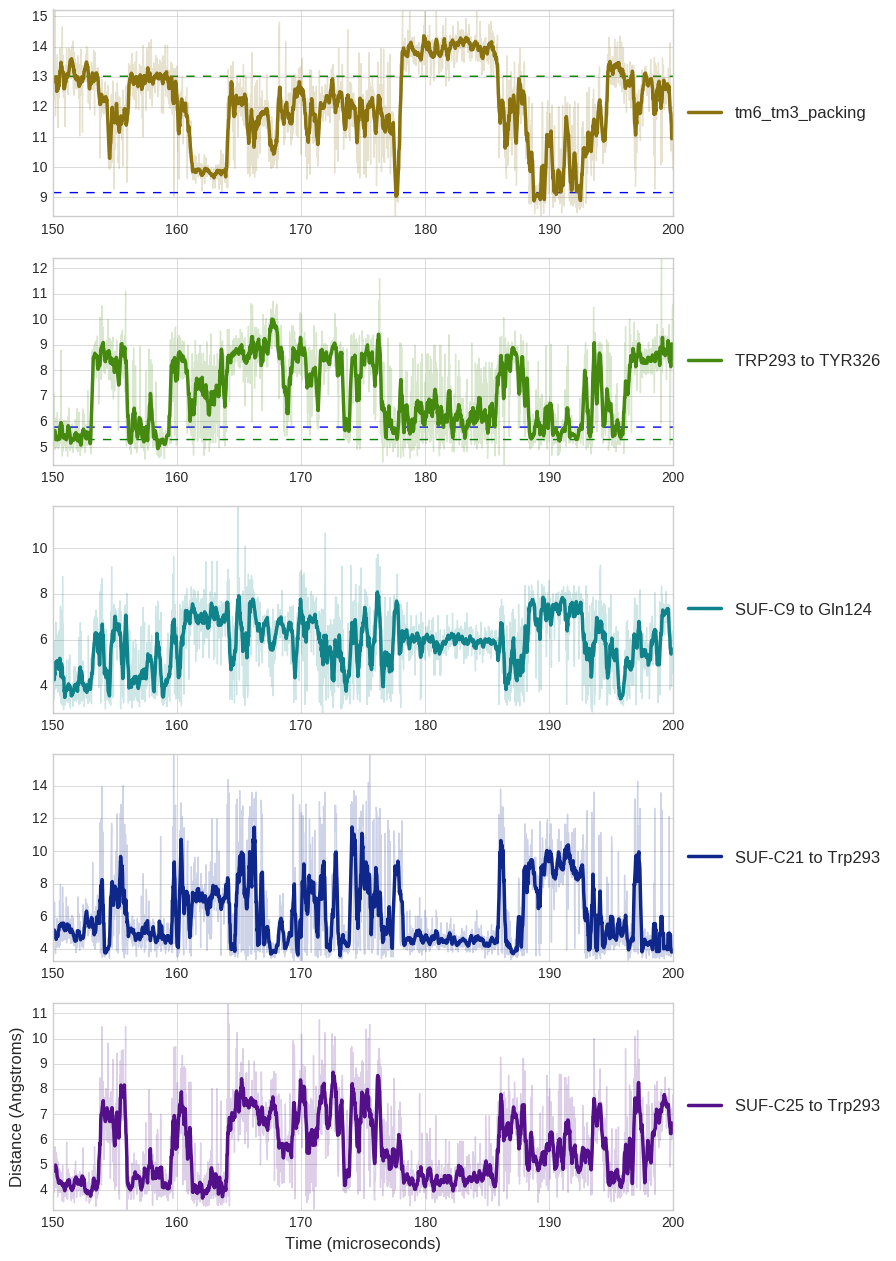

In [140]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=9
names = plmf.columns.values.tolist()
for i, name in enumerate(names):
    if "LIG" in str(name):
        names[i] = "SUF" + name[3:]
    if "Lig1" in str(name):
        names[i] = "SUF" + name[4:]
plmf.columns = names
plmf.index = (plmf.index.values * pp_msm_lag_time) / 1000

names = ref_features.columns.values.tolist()
for i, name in enumerate(names):
    if "LIG" in str(name):
        names[i] = "SUF" + name[3:]
    if "Lig1" in str(name):
        names[i] = "SUF" + name[4:]
new_ref_df = copy.deepcopy(ref_features)
new_ref_df.columns=names
#ARG277_CA to ASP340_CA < 16.816269	0.007488
#260	GLU229_CA to LEU219_CA < 9.404339	0.006515
#270	ARG277_CA to ASP340_CA < 10.488917	0.006479
#112	9.625625 < ALA240_CA to HIS297_CA < 14.355638

pp_lp_features = ["tm6_tm3_packing", "TRP293 to TYR326", "SUF-C9 to Gln124", "SUF-C21 to Trp293", "SUF-C25 to Trp293"]#, "SUF-C22 to TRP293-CD2: Pi T"]
#plot_features = plmf[["tm6_tm3_packing", "PHE338 to PHE84", "PHE289 to ASN150", "TRP293 to ALA240", "HIS319_CA to TYR75_CA", "TYR336 to ASP114",  "suf-N1 to Tyr326", "suf-C25 to Trp133", "suf-C23 to Gln124", "suf-C26 to Leu219"]]
plot_features = plmf[pp_lp_features]

plot_df_rolling(plot_features.iloc[6000:8000], "%s/key_measurements_pp_lp_rainbow3.png" %(analysis_dir), True, smoothing=smoothing, include_original=True, subplots=True, min_periods=None, ref_df=ref_features, color="not_rainbow")
plt.show()

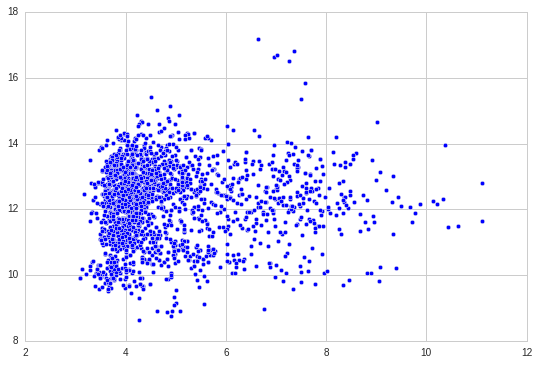

In [231]:
plt.scatter(features_eq["Lig1-C25 to Trp293"].iloc[::10], features_eq["tm6_tm3_packing"].iloc[::10])

In [56]:
all_features_conc = pd.concat(all_traj_features, axis=0)

In [57]:
projected_features = compat_verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, suf_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = compat_verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_suf_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

suf_pp_resampled_traj_index_pairs = []
for traj in suf_pp_resampled_traj_to_frames.keys():
    [suf_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in suf_pp_resampled_traj_to_frames[traj]]

apo_pp_resampled_traj_index_pairs = []
for traj in apo_pp_resampled_traj_to_frames.keys():
    [apo_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in apo_pp_resampled_traj_to_frames[traj]]

def create_features_eq_df(resampled_traj_index_pairs, feature_dfs, protein_top_features, ligand_top_features, pp_tica_resampled, ligand_tica_resampled, pp_pnas):
    all_dfs = []
    pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, resampled_traj_index_pairs)
    all_dfs.append(pp_features_eq)
    if ligand_top_features is not None:
        ligand_features_eq = resample_features_by_msm_trajectory(ligand_top_features, resampled_traj_index_pairs)
        all_dfs.append(ligand_features_eq)
    pp_tica_eq = pd.DataFrame(pp_tica_resampled, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
    all_dfs.append(pp_tica_eq)
    if ligand_tica_resampled is not None:
        ligand_tica_eq = pd.DataFrame(ligand_tica_resampled, columns=["suf tIC.%d" %i for i in range(1,n_components+1)])
        all_dfs.append(ligand_tica_eq)
    pnas_eq = pd.DataFrame(pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
    all_dfs.append(pnas_eq)
    features_eq = pd.concat(all_dfs, axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]
    return features_eq

features_eq = create_features_eq_df(suf_pp_resampled_traj_index_pairs, suf_feature_dfs, protein_top_features_suf, suf_feature_dfs, suf_pp_tica, tica_resampled, suf_pp_pnas)
apo_features_eq = create_features_eq_df(apo_pp_resampled_traj_index_pairs, None, protein_top_features_apo, None, apo_pp_tica, None, apo_pp_pnas)

features_eq_file = "%s/suf_features_eq.pkl" %analysis_dir
with open(features_eq_file, "wb") as f:
    pickle.dump(features_eq, f, protocol=2)
print(features_eq_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/tica_msm_lag-time50_clusters1000_resampled.h5"... (<class 'numpy.ndarray'>)
/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/analysis_n_clusters1000_random-1000clusters_25lag-time/suf_features_eq.pkl


In [58]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [59]:
def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [60]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

/home/enf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


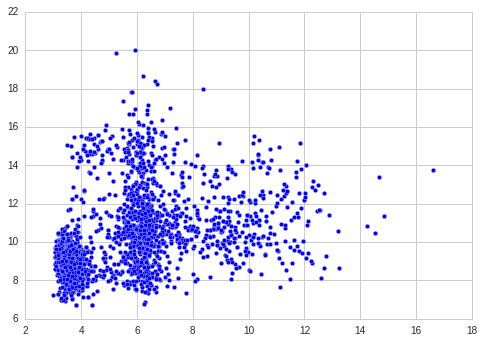

In [61]:
plt.scatter(features_eq["PHE289 to TYR336"].iloc[::10], features_eq["ILE308_CA to TRP318_CA"].iloc[::10])# bins=100)

In [174]:
ref_features["ILE308_CA to TRP318_CA"]

0    11.229031
1    11.589268
Name: ILE308_CA to TRP318_CA, dtype: float32

we are operating on biox3
plotted


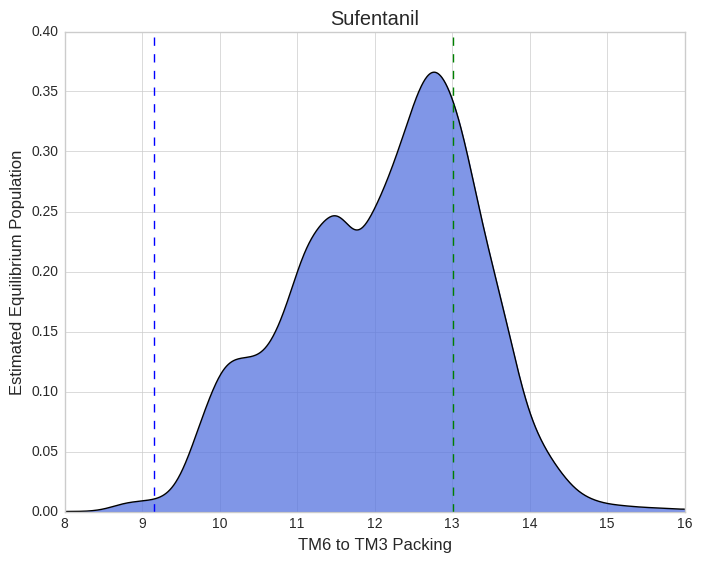

plotted


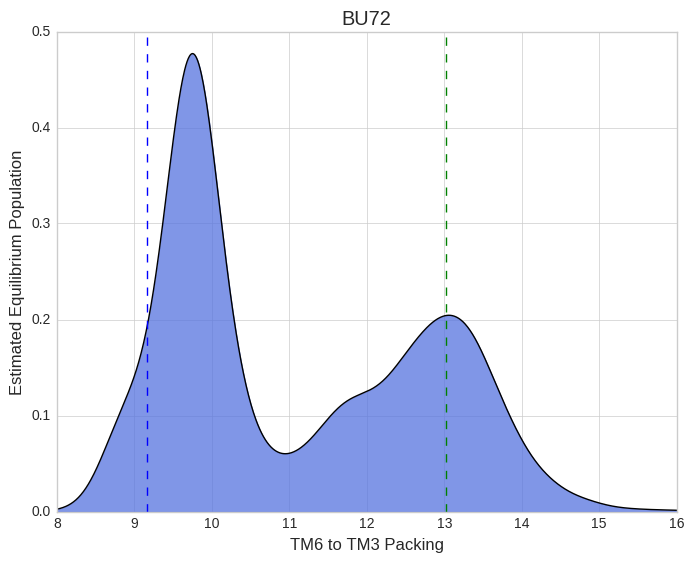

plotted


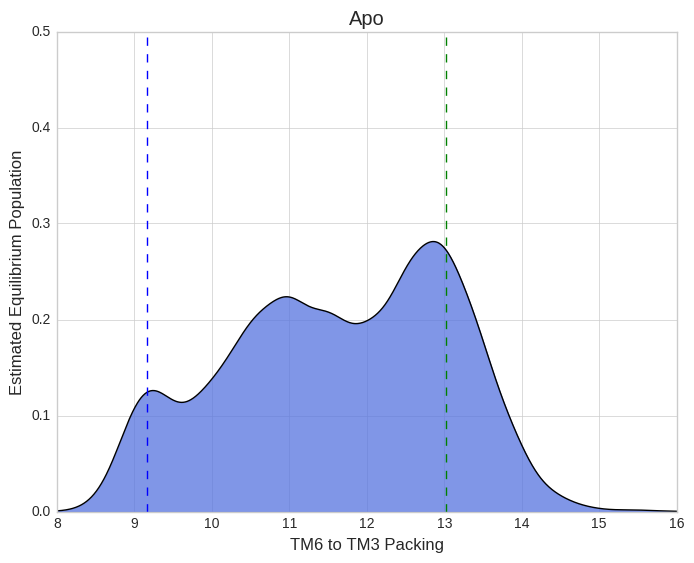

In [145]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

compute_and_plot_single_kde(features_eq["tm6_tm3_packing"].values[::1], "Sufentanil", "TM6 to TM3 Packing",
                                fig_file=None, custom_bounds=[8, 16],
                                custom_y_bounds=None, n_points=1000,
                                convert_to_energy=False, crystal_values=ref_features["tm6_tm3_packing"].values)

compute_and_plot_single_kde(bu72_features_eq["tm6_tm3_packing"].values[::1], "BU72", "TM6 to TM3 Packing",
                                fig_file=None, custom_bounds=[8, 16],
                                custom_y_bounds=None, n_points=1000,
                                convert_to_energy=False, crystal_values=ref_features["tm6_tm3_packing"].values)

compute_and_plot_single_kde(apo_features_eq["tm6_tm3_packing"].values[::1], "Apo", "TM6 to TM3 Packing",
                                fig_file=None, custom_bounds=[8, 16],
                                custom_y_bounds=[0, .5], n_points=1000,
                                convert_to_energy=False, crystal_values=ref_features["tm6_tm3_packing"].values)

(array([  2.00000000e+00,   1.10000000e+01,   2.40000000e+01,
          3.20000000e+01,   3.90000000e+01,   2.50000000e+01,
          5.00000000e+01,   3.60000000e+01,   5.50000000e+01,
          7.20000000e+01,   6.70000000e+01,   6.50000000e+01,
          7.30000000e+01,   9.30000000e+01,   7.70000000e+01,
          1.07000000e+02,   1.04000000e+02,   1.32000000e+02,
          1.37000000e+02,   1.42000000e+02,   1.56000000e+02,
          1.55000000e+02,   1.48000000e+02,   1.95000000e+02,
          2.34000000e+02,   2.56000000e+02,   3.18000000e+02,
          2.55000000e+02,   2.97000000e+02,   2.67000000e+02,
          2.13000000e+02,   1.71000000e+02,   1.74000000e+02,
          1.36000000e+02,   1.29000000e+02,   1.18000000e+02,
          1.32000000e+02,   1.23000000e+02,   1.33000000e+02,
          1.38000000e+02,   1.41000000e+02,   1.22000000e+02,
          1.13000000e+02,   1.35000000e+02,   1.15000000e+02,
          1.10000000e+02,   1.15000000e+02,   1.17000000e+02,
        

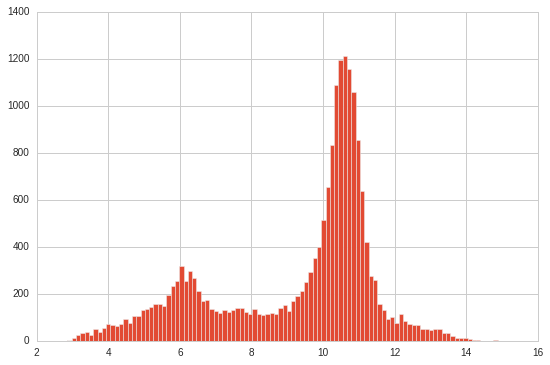

In [153]:
plt.scatter(bu72_features_eq["PHE289 to TYR336"],  bins=100)

In [252]:
all_features_conc.loc[(all_features_conc["rmsd_npxxy_inactive"] < 0.35) & (all_features_conc["tm6_tm3_packing"] < 10.5)].shape[0]/all_features_conc.shape[0]

0.011627778737670989

In [153]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

#intermediates = cluster_features_averages.loc[(cluster_features_averages["rmsd_npxxy_active"] < 0.3)].index.values# & (cluster_features_averages["Lig1-C9 to Trp318"] < 6.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["PHE338 to PHE84"] < 8.) & (cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_active"] < 5.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["rmsd_npxxy_inactive"] < 0.3) &(cluster_features_averages["tm6_tm3_packing"] < 10.5) & (cluster_features_averages["ASN150 to PHE289"] < 8.)].index.values# & (cluster_features_averages["rmsd_npxxy_active"] < 0.4)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["TRP293 to TYR326"] < 6.)].index.values# & (cluster_features_averages["ASN150 to PHE289"] > 12.)].index.values
intermediates = cluster_features_averages.loc[(cluster_features_averages["mOR tIC.1"] > 5.)].index.values# & (cluster_features_averages["TRP293 to TYR326"] < 6.)].index.values# & (cluster_features_averages["ASN150 to PHE289"] > 12.)].index.values


intermediates = intermediates.tolist()
print(intermediates)
counts = [len(suf_pp_clusters_map[i]) for i in range(0, pp_n_clusters)]
for c in np.argsort(-1.0*np.array(counts)):
    if c in intermediates:
        print(c)
#print(intermediates)
#find_most_populated_intermediates(suf_pp_msm, intermediates)

we are operating on biox3
[57, 75, 189, 210, 220, 315, 351, 380, 399, 406, 474, 491, 577, 596, 627, 649, 663, 740, 777, 923, 944, 958]
740
491
57
663
923
944
351
474
315
189
220
399
958
577
596
627
380
406
649
75
777
210


In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
intermediates = cluster_features_averages.loc[(cluster_features_averages["TYR336 to PHE289"] > 12.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["PHE289 to ASN150"] > 16.) & (cluster_features_averages["TYR336 to PHE289"] > 12.)].index.values# & (cluster_features_averages["Lig1-C9 to Trp318"] < 6.)].index.values
print(intermediates)
find_most_populated_intermediates(suf_pp_msm, intermediates)

In [85]:

all_traj_features_np = [f.values for f in all_traj_features_apo]

cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["PHE338 to PHE84"] < 10.)].index.values
print(intermediate_actives)
msm_intermediate_actives = np.concatenate(apo_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(apo_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(apo_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

#tpt_paths_features = []
#for tpt_path in inv_tpt_paths:
#    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

NameError: name 'all_traj_features_apo' is not defined

In [ ]:
prot_features = list(set([str(g) for l in suf_pp_tIC_features for g in l]))
f1 = pd.concat([f*10. for f in protein_top_features_apo], axis=0)
f2 = pd.concat([f for f in apo_tica_dfs])
f3 = pd.concat([f for f in apo_pnas_dfs])
prot_lig_features = pd.concat([f1,f2,f3],axis=1)
all_traj_features_apo = [pd.concat([protein_top_features_apo[i], apo_tica_dfs[i], apo_pnas_dfs[i]], axis=1) for i in range(0, len(apo_tica_dfs))]



all_traj_features_np = [f.values for f in all_traj_features_apo]
cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["PHE338 to PHE84"] < 8.) & (cluster_features_averages["tm6_tm3_packing"] < 10.)].index.values
msm_intermediate_actives = apo_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

In [251]:
graph_file = "%s/suf_clusters_%d_msm_lag_time%d_graph_3.graphml" % (tica_dir, n_clusters, pp_msm_lag_time)
suf_cluster_attributes = {}
for i, title in enumerate(["mOR tIC.%d" %i for i in range(1,n_components+1)]):
    suf_cluster_attributes[title] = cluster_features_averages[title].values
attributes = ["tm6_tm3_packing", "rmsd_npxxy_inactive", "Lig1-N4 to Gln124", "Lig1-N4 to Tyr326", "Lig1-C25 to Trp293", "Lig1-O2 to Trp293", "Lig1-S1 to Trp133", "HIS319_CA to TYR75_CA", "tm6_tm3_packing", "ASN150 to PHE289", "PHE289 to TYR336", "LEU88 to PHE338", "ASP114 to TYR336", "LYS303_CA to TRP318_CA", "TRP293 to TYR326", "ALA240 to TRP293", "PHE289 to PRO244", "ASP147 to TYR326"]
for attribute in attributes:
    suf_cluster_attributes[attribute] = cluster_features_averages[attribute].values
msm_attributes = {'eq_pops': suf_pp_msm.populations_}
construct_graph(suf_pp_msm_file, suf_pp_clusterer_file, pp_n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None, msm_attributes=msm_attributes, cluster_attributes=suf_cluster_attributes, min_prob=1e-3)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time25_prior-counts1e-05_clusters1000.h5"...
Number of nodes in graph:
861


In [250]:
graph_file

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/suf_clusters_1000_msm_lag_time25_graph_3.graphml'

In [ ]:
plt.scatter(all_features_conc["Lig1-C21 to Trp293"].values[::100], all_features_conc["ALA240 to TRP293"].values[::100])

In [ ]:
ref_features["ALA240 to TRP293"]

In [78]:
from importlib import reload
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

pp_feature_names = protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]
lp_feature_names = [str(f) for f in new_feature_names]

#all_pp_features_onehot, pp_names_onehot = multi_onehot_trajectories([t[pp_feature_names].values for t in all_traj_features], pp_feature_names, subsample=100, binary_keep_one=True)
#all_lp_features_onehot, lp_names_onehot = multi_onehot_trajectories([t[lp_feature_names].values for t in all_traj_features], lp_feature_names, custom_bounds=[5.0], subsample=100, binary_keep_one=True)

all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot = multi_onehot_trajectories([features_eq[pp_feature_names].values], pp_feature_names, subsample=1, binary_keep_one=True)
all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot = multi_onehot_trajectories([features_eq[lp_feature_names].values], lp_feature_names, custom_bounds=[5.0], subsample=1, binary_keep_one=True)

we are operating on biox3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


In [79]:
verbosedump((all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot, all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot), "%s/onehot_features.h5" %(analysis_dir))

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/analysis_n_clusters1000_random-1000clusters_25lag-time/onehot_features.h5"... (<class 'tuple'>)


In [80]:
print(len(lp_names_onehot))
print(len(pp_names_onehot))

373
669


In [81]:
save_name = "features_eq_multionehot_pp_vs_lp_logistic_scores"
#if 1==1:
if not os.path.exists("%s/%s.h5" %(analysis_dir, save_name)):
    data_i = pd.concat(all_lp_features_onehot, axis=0).values[::1]
    data_j = pd.concat(all_pp_features_onehot, axis=0).values[::1]
    pp_lp_scores, pp_lp_importances = compute_sl_matrix(data_i, data_j, n_trees=500, n_folds=5, max_depth=3, task="classification", model_type="logistic", worker_pool=dview, parallel=False)
    verbosedump(pp_lp_scores, "%s/%s_scores.h5" %(analysis_dir, save_name))
    verbosedump(pp_lp_importances, "%s/%s_importances.h5" %(analysis_dir, save_name))
else:
    pp_lp_scores = compat_verboseload("%s/%s_scores.h5" %(analysis_dir, save_name))
    pp_lp_importances = compat_verboseload("%s/%s_importances.h5" %(analysis_dir, save_name))




Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/analysis_n_clusters1000_random-1000clusters_25lag-time/features_eq_multionehot_pp_vs_lp_logistic_scores_scores.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/analysis_n_clusters1000_random-1000clusters_25lag-time/features_eq_multionehot_pp_vs_lp_logistic_scores_importances.h5"... (<class 'numpy.ndarray'>)


In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

save_name = "features_eq_multionehot_pp_vs_pp_logistic_scores"
if 1==1:
#if not os.path.exists("%s/%s.h5" %(analysis_dir, save_name)):
    data_i = pd.concat(all_pp_features_onehot, axis=0).values[::1]
    data_j = pd.concat(all_pp_features_onehot, axis=0).values[::1]
    pp_pp_scores, pp_pp_importances = compute_sl_matrix(data_i, data_j, n_trees=500, n_folds=5, max_depth=3, task="classification", model_type="logistic", worker_pool=dview, parallel=False, symmetric=True)
    verbosedump(pp_pp_scores, "%s/%s_scores.h5" %(analysis_dir, save_name))
    verbosedump(pp_pp_importances, "%s/%s_importances.h5" %(analysis_dir, save_name))
else:
    pp_pp_scores = compat_verboseload("%s/%s_scores.h5" %(analysis_dir, save_name))
    pp_pp_importances = compat_verboseload("%s/%s_importances.h5" %(analysis_dir, save_name))



In [ ]:
reload(matplotlib)
auc_scores_df = pd.Series(pp_lp_scores, index=pp_names_onehot).sort(ascending=False, inplace=False)
auc_scores_df = auc_scores_df.iloc[:50]
title = "Predicting Protein Conformation by Ligand Orientation"
auc_scores_df.plot(kind='barh', title=title, figsize=(5,10))
plt.xlabel("Average Test ROC AUC")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_oneshot_%s.pdf" %(analysis_dir, title))
plt.show()

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

pp_pp_importances_df = pd.DataFrame(pp_pp_importances, columns=pp_names_onehot, index=pp_names_onehot)
protein_features = ["ASN150 to PHE289", "tm6_tm3_packing", "PHE289 TO TYR336", "TYR75 to HIS319", "ASP114 to TYR336"]
plot_lp_pp_model_outcomes(pp_pp_importances_df, pp_pp_scores, analysis_dir, pd.concat(all_traj_features, axis=0), pd.concat(all_pp_features_onehot,axis=0), n_pp_features=25,
                                  n_lp_features=100, protein_features=protein_features, ref_features_df=ref_features, redo=True)

we are operating on biox3
['ASN150 to PHE289 < 7.477516', '7.477516 < ASN150 to PHE289 < 16.906253', '16.906253 < ASN150 to PHE289 < 17.750617', 'ASN150 to PHE289 > 17.750617']
ASN150 to PHE289 < 7.477516
ASN150 to PHE289
Lig1-C24 to Leu121 < 5.000000    4.984356
Lig1-C11 to Trp293 < 5.000000    4.389181
Lig1-C18 to Ala117 < 5.000000    3.950467
Lig1-C27 to Ile322 < 5.000000    3.869211
Lig1-C13 to Gly325 < 5.000000    3.332150
Lig1-C7 to Asp147 < 5.000000     3.260817
Lig1-C18 to Tyr148 < 5.000000    3.162293
Lig1-O3 to Gly325 < 5.000000     3.151219
Lig1-C17 to Ser329 < 5.000000    3.145844
Lig1-C15 to Tyr326 < 5.000000    2.881213
Lig1-C23 to Asn150 < 5.000000    2.846941
Lig1-N5 to Lys233 < 5.000000     2.783983
Lig1-C18 to Asp147 < 5.000000    2.783670
Lig1-C26 to Ile322 < 5.000000    2.616621
Lig1-S1 to Ile215 < 5.000000     2.378082
Lig1-C25 to His297 < 5.000000    2.368780
Lig1-C11 to Tyr148 < 5.000000    2.328271
Lig1-C26 to Ser125 < 5.000000    2.326370
Lig1-C8 to Asp147 < 5.

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:825: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  df = importances_df[pp_feature].loc[[n for n in


(200,)
(200,)
(200,)
Lig1-C23 to Asn150 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-N5 to Lys233 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C18 to Asp147 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C26 to Ile322 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-S1 to Ile215 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C25 to His297 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C11 to Tyr148 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C26 to Ser125 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C8 to Asp147 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C21 to Trp318 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C24 to Asp216 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C13 to Ile322 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C21 to Phe237 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C6 to Lys233 < 5.000000
ASN150 to PHE289
(200,)
(200,)
(200,)
Lig1-C6 to Asp147 < 5.000000
AS

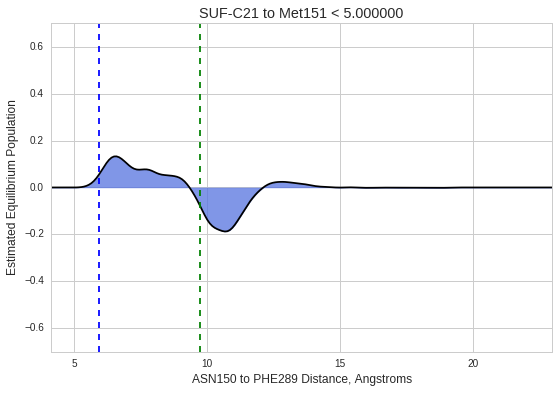

In [99]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import * 

pp_lp_importances_df = pd.DataFrame(pp_lp_importances, columns=pp_names_onehot, index=lp_names_onehot)

protein_features = ["ASN"]#, "TRP293 to TYR326", "PHE289 TO TYR336", "TYR75 to HIS319", "ASP114 to TYR336"]
plot_lp_pp_model_outcomes(pp_lp_importances_df, pp_lp_scores, analysis_dir, features_eq, pd.concat(all_lp_features_onehot,axis=0), n_pp_features=0,
                                  n_lp_features=100, protein_features=protein_features, ref_features_df=ref_features, redo=False)

In [ ]:
pp_pp_importances_df = pd.DataFrame(pp_pp_importances, columns=pp_names_onehot, index=pp_names_onehot)
pp_lp_importances_df = pd.DataFrame(pp_lp_importances, columns=pp_names_onehot, index=lp_names_onehot)

pp_lp_edge_df = make_edge_list(pp_lp_scores, pp_lp_importances_df).sort("importance", inplace=False, ascending=False)
pp_pp_edge_df = make_edge_list(pp_pp_scores, pp_pp_importances_df).sort("importance", inplace=False, ascending=False)
edge_df = pd.concat([pp_lp_edge_df, pp_pp_edge_df], axis=0)


In [ ]:
edge_df.loc[(edge_df.feature_i.str.contains('Lig')) & (edge_df.feature_j.str.contains('tm6_tm3_packing'))]

In [ ]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

graph_file = "%s/logistic_graph_cutoff1pt0.graphml" %analysis_dir

new_edge_df = copy.deepcopy(edge_df)
new_edge_df.feature_i =edge_df.feature_j
new_edge_df.feature_j = edge_df.feature_i
build_causality_network(new_edge_df, graph_file, min_importance=0., lig_name="lig")

In [ ]:
#protein_features = ["PHE289 to ASN150", "tm6_tm3_packing", "MET281_CA to MET161_CA", "TYR336 to PHE289", "HIS319 to TYR75"]
plot_lp_pp_model_outcomes(importances_df, onehot_scores, save_dir, features_eq, n_pp_features=25,
                                  n_lp_features=75, protein_features=None, ref_features_df=ref_features)

In [102]:
import transfer_entropy_analysis
from imp import reload
reload(transfer_entropy_analysis)
from transfer_entropy_analysis import *

In [68]:
%load_ext autoreload
%autoreload 2

In [69]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

In [103]:


all_pp_features_onehot_np, pp_names_onehot, all_pp_features_onehot = multi_onehot_trajectories([t[pp_feature_names].values for t in all_traj_features], pp_feature_names, subsample=100, binary_keep_one=True)
all_lp_features_onehot_np, lp_names_onehot, all_lp_features_onehot = multi_onehot_trajectories([t[lp_feature_names].values for t in all_traj_features], lp_feature_names, custom_bounds=[5.0], subsample=100, binary_keep_one=True)

timeseries_i = [pd.concat([all_lp_features_onehot[i], all_pp_features_onehot[i]], axis=1) for i in range(0, len(all_lp_features_onehot))]
timeseries_j = [pd.concat([all_lp_features_onehot[i], all_pp_features_onehot[i]], axis=1) for i in range(0, len(all_lp_features_onehot))]

titles_i = timeseries_i[0].columns.values[::1].tolist()
titles_j = timeseries_j[1].columns.values[::1].tolist()

timeseries_i = [t.values[:,::1] for t in timeseries_i]
timeseries_j = [t.values[:,::1] for t in timeseries_j]

#tentropy_array, tentropy_pairs_id_tuples, tentropy_pairs_names = compute_tentropy_between(list(zip(timeseries_i, timeseries_j)), 5,
#                                                                                         titles_i=titles_i, titles_j=titles_j, n_shuffle=0, worker_pool=dview,
#                                                                                         parallel=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


In [66]:
tent_file = "%s/suf_tent_nosubtract.pkl" %traj_dir
if not os.path.exists(tent_file):
    tent_df = get_tentropy_df(tentropy_array, tentropy_pairs_id_tuples, tentropy_pairs_names, tent_file)
else:
    with open(tent_file, "rb") as f:
        tent_df = pickle.load(f)

In [127]:
tent_df = process_tent_df(tent_df, old_ligand_name="Lig1", new_ligand_name="SUF")
cutoff = 1e-3
save_file = "%s/SUF_nosubtract_cutoff%s_graph.graphml" %(analysis_dir, str(cutoff))
causality_graph_file_transpose = "%s/SUF_nosubtract_cutoff%s_graph_transpose.graphml" %(analysis_dir, str(cutoff))

causality_graph, causality_graph_transpose = build_causality_network(tent_df, save_file, cutoff, "SUF", log=False, save_transpose=True, transpose_file=causality_graph_file_transpose)

About to process TEntropy DF
Processing TEntropy DF
Removing bad entries.
Finished looping through all feature pairs. Making DF...


(array([   1.,    0.,    0.,    0.,    0.,    1.,    1.,    1.,    0.,
           1.,    2.,    3.,    3.,    3.,    1.,    4.,    2.,    1.,
           2.,    2.,    3.,    0.,    5.,    5.,    5.,    5.,    3.,
           4.,    5.,   20.,   15.,   19.,   18.,   24.,   35.,   53.,
          58.,   64.,   83.,  103.,   87.,  114.,  127.,  154.,  173.,
         151.,  185.,  187.,  220.,  192.,  217.,  185.,  206.,  203.,
         201.,  176.,  182.,  160.,  145.,  135.,  142.,  118.,  127.,
         130.,  114.,  117.,  112.,  148.,  108.,  143.,  150.,  155.,
         141.,  176.,  182.,  129.,  153.,  148.,  163.,  145.,  162.,
         146.,  165.,  203.,  167.,  130.,  141.,  114.,  186.,  110.,
         128.,  133.,  148.,  139.,  145.,  147.,   97.,   67.,  108.,
         104.,   51.,   97.,  100.,   82.,   57.,   57.,   61.,   44.,
          68.,   73.,   65.,   59.,   49.,   57.,   57.,   46.,   40.,
          59.,   38.,   38.,   57.,   36.,   32.,   29.,   29.,   25.,
      

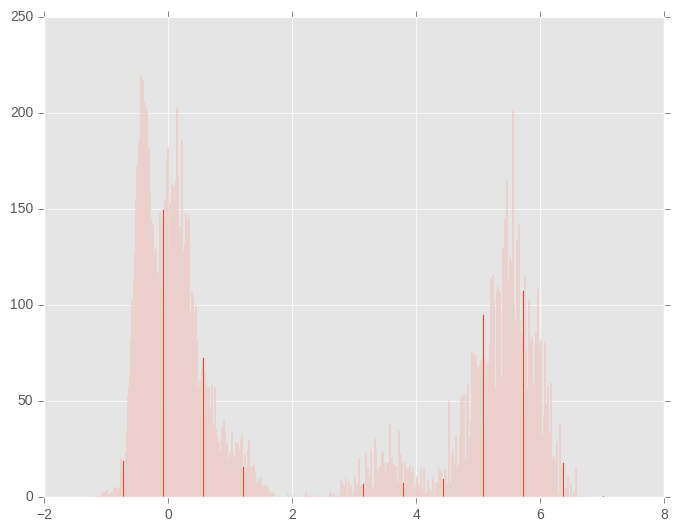

In [149]:
plt.hist(features_eq["mOR tIC.1"].values, bins=500)

In [154]:
[n for n in causality_graph.nodes() if "tIC.1 " in n]

['mOR tIC.1 < 3.624736']

In [152]:
#causality_graph_transpose["mOR tIC.1 < 3.624736"]

df = pd.DataFrame([(key, value['weight']) for key, value in causality_graph_transpose["mOR tIC.1 < 3.624736"].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
#df = pd.DataFrame([(key, value['weight']) for key, value in top_causality_graph["LYS233_CA to LYS303_CA < 9.207879"].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
df.loc[df.edge.str.contains("SUF")]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


edge    weight
9    SUF-C18 to Ala117 < 5.000000  0.004235
65   SUF-C17 to Asp147 < 5.000000  0.004129
146  SUF-C14 to Met151 < 5.000000  0.003942
29    SUF-N4 to Gln124 < 5.000000  0.003883
15    SUF-O3 to Met151 < 5.000000  0.003793
117  SUF-C27 to Cys217 < 5.000000  0.003640
38   SUF-C17 to Ile296 < 5.000000  0.003248
70   SUF-C25 to Asn150 < 5.000000  0.003211
42   SUF-C13 to Ala117 < 5.000000  0.003192
23    SUF-N5 to Ile296 < 5.000000  0.003149
132  SUF-C25 to Ser329 < 5.000000  0.003026
131  SUF-C22 to Trp293 < 5.000000  0.002990
111   SUF-C7 to Gln124 < 5.000000  0.002953
86   SUF-C24 to Val143 < 5.000000  0.002815
8    SUF-C21 to Trp293 < 5.000000  0.002742
63   SUF-C14 to His297 < 5.000000  0.002669
74   SUF-C27 to Cys140 < 5.000000  0.002648
52   SUF-C11 to Gly325 < 5.000000  0.002646
143   SUF-O2 to Cys321 < 5.000000  0.002584
104  SUF-C24 to Ile144 < 5.000000  0.002536
48    SUF-N4 to Val143 < 5.000000  0.002506
101  SUF-C25 to Met151 < 5.000000  0.002404
68   SUF-C23 to Asp147 < 5.000000  0.002403
102   SUF-C6 to Gln124 < 5.000000  0.002403
35   SUF-C13 to Gly325 < 5.000000  0.002398
73   SUF-C22 to Ile296 < 5.000000  0.002388
135   SUF-C7 to Thr120 < 5.000000  0.002347
27   SUF-C26 to Gln124 < 5.000000  0.002346
24   SUF-C16 to Met151 < 5.000000  0.002316
133  SUF-C17 to Gly325 < 5.000000  0.002297
110  SUF-C13 to Ile296 < 5.000000  0.002277
144   SUF-C9 to Ala117 < 5.000000  0.002249
103   SUF-N5 to Gly325 < 5.000000  0.002222
134  SUF-C26 to Val143 < 5.000000  0.002158
79   SUF-C19 to Phe123 < 5.000000  0.002117
45    SUF-S1 to Val143 < 5.000000  0.002100
53    SUF-S1 to Tyr326 < 5.000000  0.002035
37   SUF-C22 to Gly325 < 5.000000  0.002032
54   SUF-C24 to Asn127 < 5.000000  0.002030
100  SUF-C20 to Tyr326 < 5.000000  0.001979
28   SUF-C23 to Trp293 < 5.000000  0.001953
121  SUF-C19 to Trp133 < 5.000000  0.001945
75    SUF-N5 to Met151 < 5.000000  0.001920
125   SUF-C7 to Ala117 < 5.000000  0.001905
116   SUF-S1 to Cys140 < 5.000000  0.001881
92   SUF-C27 to Asn127 < 5.000000  0.001866
94   SUF-C21 to Val300 < 5.000000  0.001863
62   SUF-C27 to Phe135 < 5.000000  0.001862
87   SUF-C25 to Asp114 < 5.000000  0.001842
20   SUF-C27 to Thr218 < 5.000000  0.001840
90   SUF-C22 to Tyr326 < 5.000000  0.001797
69   SUF-C12 to Tyr326 < 5.000000  0.001720
130   SUF-N4 to Tyr326 < 5.000000  0.001718
2    SUF-C16 to Val236 < 5.000000  0.001690
136  SUF-C18 to Trp293 < 5.000000  0.001678
97   SUF-C18 to Asp147 < 5.000000  0.001657
80    SUF-C7 to Asp147 < 5.000000  0.001648
85    SUF-C6 to Asp147 < 5.000000  0.001638
112  SUF-C22 to Asp147 < 5.000000  0.001621
7    SUF-C17 to Ser329 < 5.000000  0.001552
18   SUF-C17 to Ala117 < 5.000000  0.001552
78   SUF-C15 to Asp147 < 5.000000  0.001532
119  SUF-C23 to Tyr148 < 5.000000  0.001530
47   SUF-C14 to Tyr148 < 5.000000  0.001511
59   SUF-C26 to Thr120 < 5.000000  0.001501
51   SUF-C17 to Tyr326 < 5.000000  0.001496
106  SUF-C10 to Tyr299 < 5.000000  0.001483
36    SUF-C6 to Tyr326 < 5.000000  0.001430
50   SUF-C24 to Phe123 < 5.000000  0.001388
138   SUF-N5 to Asp147 < 5.000000  0.001367
109   SUF-N4 to Thr120 < 5.000000  0.001354
4     SUF-S1 to Trp133 < 5.000000  0.001341
39   SUF-C25 to Ala113 < 5.000000  0.001331
22   SUF-C14 to Asp147 < 5.000000  0.001271
55   SUF-C11 to Ile296 < 5.000000  0.001270
91    SUF-S1 to Asp216 < 5.000000  0.001189
71   SUF-C23 to Ala117 < 5.000000  0.001172
14   SUF-C27 to Asp216 < 5.000000  0.001159
84   SUF-C23 to Tyr326 < 5.000000  0.001158
17   SUF-C15 to Tyr326 < 5.000000  0.001144
129  SUF-C23 to Ser329 < 5.000000  0.001114
120  SUF-C23 to Asp114 < 5.000000  0.001091
105   SUF-C9 to Asp147 < 5.000000  0.001081
140   SUF-O3 to Lys233 < 5.000000  0.001078
10   SUF-C24 to Trp133 < 5.000000  0.001023
108   SUF-C9 to Gln124 < 5.000000  0.001020
49   SUF-C22 to Ala113 < 5.000000  0.001009

In [ ]:
#lig_nodes = [l for l in causality_graph.nodes() if "lig" in l.lower() or "bu" in l.lower()]
#target = [l for l in causality_graph.nodes() if "tm6_tm3_packing" in l][0]
#path_importances, feature_importances = compute_sources_target_importances(graph=causality_graph, sources=lig_nodes, target=target, k=100, weight="inverse_weight", worker_pool=dview)

In [ ]:
#feature_importances[feature_importances['feature'].str.contains('BU')]

In [ ]:
#tent_df.loc[[n for n in df.index.values.tolist() if ("bu" in n.lower()) and "tm6_tm3_packing" in n]].sort("importance", inplace=False, ascending=False).iloc[:10]

In [71]:
tent_df.shape

(478821, 4)

In [106]:
top_tuples = tent_df.loc[tent_df.importance > 1e-2]["tuples"].values.tolist()
print(len(top_tuples))

32811


In [ ]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *


#top_tentropy_array, top_tentropy_pairs_id_tuples, top_tentropy_pairs_names = compute_tentropy_between(list(zip(timeseries_i, timeseries_j)), lag_time=5,
#                                                                                         titles_i=titles_i, titles_j=titles_j, n_shuffle=25, worker_pool=dview,
#                                                                                         parallel=False, i_j_pairs=top_tuples)


In [72]:
top_tent_df_file = "%s/suf_tent_top_df_subtracted.pkl" %traj_dir
if os.path.exists(top_tent_df_file):
    with open(top_tent_df_file, "rb") as f:
        top_tent_df = pickle.load(f)
else: 
    top_tent_df = get_tentropy_df(top_tentropy_array, top_tentropy_pairs_id_tuples, top_tentropy_pairs_names, top_tent_df_file)
top_tent_df = process_tent_df(top_tent_df, old_ligand_name="Lig1", new_ligand_name="SUF")

About to process TEntropy DF
Processing TEntropy DF
Removing bad entries.
Finished looping through all feature pairs. Making DF...


In [108]:
#top_tent_df.iloc[:10]

In [109]:
#top_tent_df.shape

In [110]:
#df.loc[[n for n in df.index.values.tolist() if "lig" in n.lower() or "bu" in n.lower() and "tm6_tm3_packing" in n]].iloc[:30]

In [88]:
causality_graph_file = "%s/causality_graph_top30k_cutoff0.graphml" %analysis_dir
causality_graph_file_transpose = "%s/causality_graph_top30k_cutoff0_transpose.graphml" %analysis_dir
top_causality_graph, top_causality_graph_transpose = build_causality_network(top_tent_df, causality_graph_file, 0., "suf", log=False, save_transpose=True, transpose_file=causality_graph_file_transpose)
print(len(top_causality_graph.nodes()))
print(len(top_causality_graph.edges()))

551
32811


In [103]:
import mdentropy.examples.transfer_entropy_analysis
reload(mdentropy.examples.transfer_entropy_analysis)
from mdentropy.examples.transfer_entropy_analysis import *

lig_nodes = [l for l in causality_graph.nodes() if "lig" in l.lower() or "suf" in l.lower()]
target = [l for l in causality_graph.nodes() if 'tm6_tm3_packing' in l][1]
feature_df, path_df = compute_sources_target_importances(graph=causality_graph, sources=lig_nodes, target=target,
                                                                                  k=1000, weight="inverse_weight", worker_pool=dview)

Done computing paths. Merging dictionaries now.
LYS233 to VAL300 < 6.364178
SUF-C18 to Tyr148 < 5.000000
SUF-C20 to Trp293 < 5.000000
SUF-C23 to Val236 < 5.000000
SUF-N5 to Met151 < 5.000000
SUF-C9 to Ile322 < 5.000000
SUF-C20 to Gln124 < 5.000000
PHE289 to TYR336 < 4.550262
SUF-C21 to Trp293 < 5.000000
SUF-O2 to Gln124 < 5.000000
SUF-C12 to Tyr128 < 5.000000
mOR tIC.3 < 2.189116
LEU88 to PHE338 < 6.017082
SUF-C16 to Phe237 < 5.000000
SUF-C6 to Lys233 < 5.000000
SUF-C13 to Ala117 < 5.000000
SUF-C19 to Tyr128 < 5.000000
SUF-S1 to Tyr326 < 5.000000
SUF-O2 to His297 < 5.000000
ARG165_CA to THR279_CA < 9.278176
SUF-C6 to Met151 < 5.000000
SUF-C26 to Leu121 < 5.000000
SUF-C14 to Asp147 < 5.000000
SUF-C20 to Ala304 < 5.000000
SUF-O3 to Val300 < 5.000000
SUF-C15 to Ile144 < 5.000000
SUF-C16 to Met151 < 5.000000
SUF-C17 to Val236 < 5.000000
SUF-C23 to Gly325 < 5.000000
SUF-C21 to Lys233 < 5.000000
SUF-C20 to Tyr326 < 5.000000
SUF-C18 to Ile296 < 5.000000
SUF-C18 to Asp147 < 5.000000
SUF-N4 to 

/vspdata/vspcompute/home/enf/software/mdentropy/mdentropy/examples/transfer_entropy_analysis.py:315: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  feature_importances = pd.DataFrame(feature_importances, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
/vspdata/vspcompute/home/enf/software/mdentropy/mdentropy/examples/transfer_entropy_analysis.py:318: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  path_importances = pd.DataFrame(path_importances, columns=["path", "importance"]).sort("importance", ascending=False, inplace=False)


In [92]:
top_tm6_paths = "%s/suf_top_tm6_paths.pkl" %traj_dir
if not os.path.exists(top_tm6_paths):
#if 1==1:
    tent_feature_df, tent_path_df = compute_sources_target_importances(graph=top_causality_graph, sources=lig_nodes, target=target,
                                                                                  k=1000, weight="inverse_weight", worker_pool=dview, parallel=False)
    with open(top_tm6_paths, "wb") as f:
        pickle.dump((tent_feature_df, tent_path_df), f)
else:
    with open(top_tm6_paths, "rb") as f:
        tent_feature_df, tent_path_df = pickle.load(f)

Done computing paths. Merging dictionaries now.


/vspdata/vspcompute/home/enf/software/mdentropy/mdentropy/examples/transfer_entropy_analysis.py:315: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  feature_importances = pd.DataFrame(feature_importances, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
/vspdata/vspcompute/home/enf/software/mdentropy/mdentropy/examples/transfer_entropy_analysis.py:318: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  path_importances = pd.DataFrame(path_importances, columns=["path", "importance"]).sort("importance", ascending=False, inplace=False)


In [108]:
sub_df = feature_df.loc[(feature_df.feature.str.contains("SUF")) & (feature_df.feature.str.contains("<"))]# & (tent_feature_df.feature.str.contains("<"))]# & (tent_feature_df.feature.str.contains("<"))]
#sub_df.index = sub_df.feature
#sub_df = pd.concat([sub_df, get_xtal_vals(sub_df.feature.values.tolist())], axis=1, join='outer').sort("importance", inplace=False, ascending=False)
sub_df.iloc[:100]

feature  importance
387  SUF-C20 to Ile296 < 5.000000    0.004880
305  SUF-C11 to Ile322 < 5.000000    0.003889
363  SUF-C17 to Gly325 < 5.000000    0.002488
54   SUF-C26 to Asn127 < 5.000000    0.002016
28   SUF-C23 to Gly325 < 5.000000    0.001602
446  SUF-C22 to Tyr326 < 5.000000    0.001412
172  SUF-C17 to Tyr326 < 5.000000    0.001386
25   SUF-C15 to Ile144 < 5.000000    0.001360
146  SUF-C16 to Trp293 < 5.000000    0.001351
151  SUF-C26 to Gln124 < 5.000000    0.001318
178  SUF-C15 to Val143 < 5.000000    0.001318
343  SUF-C13 to Ile296 < 5.000000    0.001281
340   SUF-S1 to Phe123 < 5.000000    0.001228
126   SUF-O2 to Ile296 < 5.000000    0.001183
456  SUF-C23 to Trp293 < 5.000000    0.001152
378  SUF-C18 to Met151 < 5.000000    0.001143
430   SUF-O3 to Tyr148 < 5.000000    0.001100
276  SUF-C21 to Met151 < 5.000000    0.001097
483   SUF-C9 to Tyr326 < 5.000000    0.001079
179  SUF-C22 to Trp293 < 5.000000    0.001051
78   SUF-C25 to Trp293 < 5.000000    0.001044
46    SUF-N4 to Gln124 < 5.000000    0.001021
384  SUF-C25 to Gly325 < 5.000000    0.001004
415   SUF-N5 to Ile296 < 5.000000    0.000985
193   SUF-O3 to Met151 < 5.000000    0.000944
209  SUF-C27 to Asn127 < 5.000000    0.000943
8    SUF-C21 to Trp293 < 5.000000    0.000921
403  SUF-C16 to Val300 < 5.000000    0.000921
440  SUF-C20 to Cys321 < 5.000000    0.000892
356  SUF-C11 to Val300 < 5.000000    0.000887
5     SUF-C9 to Ile322 < 5.000000    0.000853
465  SUF-C16 to Ile296 < 5.000000    0.000824
160   SUF-C7 to Tyr326 < 5.000000    0.000817
196  SUF-C13 to Met151 < 5.000000    0.000764
244  SUF-C14 to Met151 < 5.000000    0.000757
462  SUF-C24 to Ile144 < 5.000000    0.000749
288  SUF-C14 to Val300 < 5.000000    0.000740
321  SUF-C24 to Thr120 < 5.000000    0.000719
348  SUF-C27 to Cys217 < 5.000000    0.000714
134  SUF-C17 to Val300 < 5.000000    0.000708
458  SUF-C21 to Ile296 < 5.000000    0.000694
304  SUF-C27 to Ile144 < 5.000000    0.000685
230  SUF-C14 to Tyr148 < 5.000000    0.000660
427  SUF-C22 to Cys321 < 5.000000    0.000660
264  SUF-C17 to Trp293 < 5.000000    0.000650
242  SUF-C23 to Met151 < 5.000000    0.000649
329  SUF-C19 to Val143 < 5.000000    0.000648
49   SUF-C27 to Trp133 < 5.000000    0.000647
6    SUF-C20 to Gln124 < 5.000000    0.000644
62   SUF-C23 to Asp147 < 5.000000    0.000625
26   SUF-C16 to Met151 < 5.000000    0.000613
163  SUF-C21 to His297 < 5.000000    0.000601
191  SUF-C10 to Tyr148 < 5.000000    0.000585
395  SUF-C17 to Ile296 < 5.000000    0.000577
142  SUF-C14 to Ile296 < 5.000000    0.000543
139   SUF-S1 to Cys217 < 5.000000    0.000541
55    SUF-C9 to Gln124 < 5.000000    0.000541
161  SUF-C17 to Ile322 < 5.000000    0.000519
53   SUF-C25 to Asp147 < 5.000000    0.000515
37   SUF-C16 to Tyr148 < 5.000000    0.000513
162   SUF-C7 to Ile322 < 5.000000    0.000510
254  SUF-C24 to Trp133 < 5.000000    0.000508
383  SUF-C26 to Cys217 < 5.000000    0.000506
368   SUF-N5 to Asp147 < 5.000000    0.000499
362  SUF-C25 to Ser329 < 5.000000    0.000494
339  SUF-C15 to Tyr326 < 5.000000    0.000490
38   SUF-C23 to Tyr326 < 5.000000    0.000489
24    SUF-O3 to Val300 < 5.000000    0.000488
394  SUF-C21 to Val300 < 5.000000    0.000486
218  SUF-C15 to Thr120 < 5.000000    0.000472
114  SUF-C20 to Tyr299 < 5.000000    0.000468
73   SUF-C18 to Asn150 < 5.000000    0.000467
165  SUF-C13 to Tyr326 < 5.000000    0.000467
167  SUF-C26 to Phe123 < 5.000000    0.000454
153  SUF-C24 to Cys217 < 5.000000    0.000454
105   SUF-O2 to Ile322 < 5.000000    0.000441
195  SUF-C25 to Tyr326 < 5.000000    0.000433
406   SUF-O3 to Trp318 < 5.000000    0.000423
423  SUF-C13 to Trp293 < 5.000000    0.000421
337  SUF-C22 to Asp114 < 5.000000    0.000417
214  SUF-C19 to Thr120 < 5.000000    0.000417
56   SUF-C21 to Tyr148 < 5.000000    0.000415
9     SUF-O2 to Gln124 < 5.000000    0.000412
400  SUF-C25 to Met151 < 5.000000    0.000408
380  SUF-C19 to Ile144 < 5.000000    0.000407
75   SUF-C16 to His297 < 5.000000    0.000402
171  SUF-C12 to Thr120 <

In [101]:
tent_feature_df

Empty DataFrame
Columns: [feature, importance]
Index: []

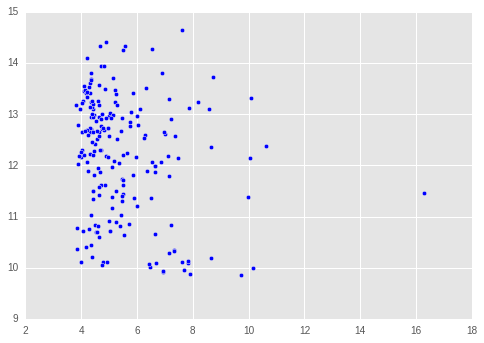

In [119]:
plt.scatter(features_eq["Lig1-C17 to Tyr326"].iloc[::100], features_eq["tm6_tm3_packing"].iloc[::100])

In [125]:
len(list(causality_graph.edges()))

228757

In [ ]:
plt.scatter(all_features_conc["Lig1-S1 to Trp133"].values[::500], all_features_conc["rmsd_npxxy_active"].values[::500])

In [ ]:
[l for l in top_causality_graph.nodes() if "packing" in l]

In [ ]:
def get_xtal_vals(feature_list):
    ref_feature_names = ref_features.columns.values.tolist()
    final_names = []
    full_final_names = []
    for feature in feature_list:
        ori_feature = get_ori_feature_name(feature)
        if ori_feature in ref_feature_names:
            final_names.append(ori_feature)
            full_final_names.append(feature)
    xtal_vals = ref_features[final_names].transpose()
    xtal_vals.columns = ["Inactive Crystal", "Active Crystal"]
    xtal_vals.index = full_final_names
    return(xtal_vals)

In [128]:
pr = nx.pagerank(causality_graph, weight="weight")
pr_t = nx.pagerank(causality_graph_transpose, weight="weight")

#hits, authorities = nx.hits(causality_graph)
#hits_t, authorities_t = nx.hits(causality_graph_transpose)



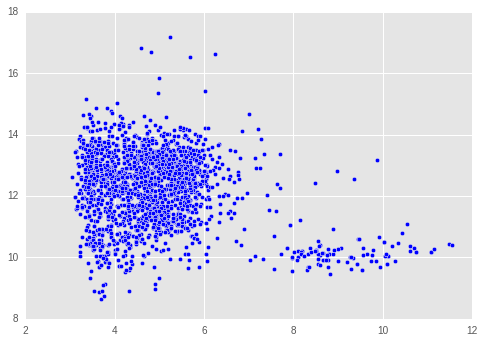

In [86]:
plt.scatter(features_eq["Lig1-C23 to Asp147"].iloc[::10], features_eq["tm6_tm3_packing"].iloc[::10])

In [129]:
node_prs = [(node, pr) for node, pr in pr_t.items()]
pr_df = pd.DataFrame(node_prs, columns=["feature", "importance"]).sort("importance", ascending=False, inplace=False)
pr_df.index = pr_df.feature
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import standardize_df
pr_df = pr_df.loc[pr_df.feature.str.contains("SUF")]
pr_df = standardize_df(pr_df, columns=["importance"])
#pr_df = pd.concat([pr_df, get_xtal_vals(pr_df.feature.values.tolist())], axis=1, join='outer').sort("importance", inplace=False, ascending=False)
#pr_df = pr_df.loc[pr_df.feature.str.contains("PHE338")]
pr_df.iloc[:100]
#pr_df.loc[pr_df.feature.str.contains("Gln")].iloc[:100]

/home/enf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


feature  importance
feature                                                               
SUF-C22 to Tyr326 < 5.000000  SUF-C22 to Tyr326 < 5.000000    2.574920
SUF-C18 to Met151 < 5.000000  SUF-C18 to Met151 < 5.000000    2.544589
SUF-C23 to Met151 < 5.000000  SUF-C23 to Met151 < 5.000000    2.484050
SUF-C21 to Met151 < 5.000000  SUF-C21 to Met151 < 5.000000    2.395369
SUF-C17 to Tyr326 < 5.000000  SUF-C17 to Tyr326 < 5.000000    2.312721
SUF-C25 to Tyr326 < 5.000000  SUF-C25 to Tyr326 < 5.000000    2.296746
SUF-C21 to Trp293 < 5.000000  SUF-C21 to Trp293 < 5.000000    2.295348
SUF-C16 to Met151 < 5.000000  SUF-C16 to Met151 < 5.000000    2.218007
SUF-C16 to Ile296 < 5.000000  SUF-C16 to Ile296 < 5.000000    2.204970
SUF-C21 to Ile296 < 5.000000  SUF-C21 to Ile296 < 5.000000    2.182568
SUF-C16 to Trp293 < 5.000000  SUF-C16 to Trp293 < 5.000000    2.148311
SUF-C7 to Tyr326 < 5.000000    SUF-C7 to Tyr326 < 5.000000    2.112181
SUF-C25 to Gly325 < 5.000000  SUF-C25 to Gly325 < 5.000000    2.067397
SUF-O3 to Tyr148 < 5.000000    SUF-O3 to Tyr148 < 5.000000    2.034900
SUF-C14 to Ile296 < 5.000000  SUF-C14 to Ile296 < 5.000000    2.029986
SUF-C9 to Gln124 < 5.000000    SUF-C9 to Gln124 < 5.000000    2.008900
SUF-C20 to Cys321 < 5.000000  SUF-C20 to Cys321 < 5.000000    2.000286
SUF-C21 to His297 < 5.000000  SUF-C21 to His297 < 5.000000    1.988263
SUF-C9 to Tyr326 < 5.000000    SUF-C9 to Tyr326 < 5.000000    1.947195
SUF-C17 to Ile322 < 5.000000  SUF-C17 to Ile322 < 5.000000    1.927433
SUF-C20 to Gln124 < 5.000000  SUF-C20 to Gln124 < 5.000000    1.925471
SUF-C8 to Tyr148 < 5.000000    SUF-C8 to Tyr148 < 5.000000    1.884339
SUF-C22 to Ile322 < 5.000000  SUF-C22 to Ile322 < 5.000000    1.863773
SUF-C9 to Ile322 < 5.000000    SUF-C9 to Ile322 < 5.000000    1.830593
SUF-C23 to Trp293 < 5.000000  SUF-C23 to Trp293 < 5.000000    1.731209
SUF-C25 to Ile322 < 5.000000  SUF-C25 to Ile322 < 5.000000    1.721761
SUF-C23 to Asp147 < 5.000000  SUF-C23 to Asp147 < 5.000000    1.718802
SUF-C25 to Met151 < 5.000000  SUF-C25 to Met151 < 5.000000    1.702312
SUF-C23 to Tyr326 < 5.000000  SUF-C23 to Tyr326 < 5.000000    1.694907
SUF-C27 to Cys217 < 5.000000  SUF-C27 to Cys217 < 5.000000    1.680023
SUF-C10 to Tyr148 < 5.000000  SUF-C10 to Tyr148 < 5.000000    1.632796
SUF-C15 to Thr120 < 5.000000  SUF-C15 to Thr120 < 5.000000    1.629878
SUF-C26 to Cys217 < 5.000000  SUF-C26 to Cys217 < 5.000000    1.614665
SUF-C7 to Ile322 < 5.000000    SUF-C7 to Ile322 < 5.000000    1.597458
SUF-C20 to Ile296 < 5.000000  SUF-C20 to Ile296 < 5.000000    1.595554
SUF-O2 to Gln124 < 5.000000    SUF-O2 to Gln124 < 5.000000    1.569351
SUF-C17 to Trp293 < 5.000000  SUF-C17 to Trp293 < 5.000000    1.565176
SUF-C17 to Ile296 < 5.000000  SUF-C17 to Ile296 < 5.000000    1.563768
SUF-C15 to Ile144 < 5.000000  SUF-C15 to Ile144 < 5.000000    1.557093
SUF-C19 to Ile144 < 5.000000  SUF-C19 to Ile144 < 5.000000    1.525504
SUF-C22 to Gly325 < 5.000000  SUF-C22 to Gly325 < 5.000000    1.523073
SUF-C18 to Trp293 < 5.000000  SUF-C18 to Trp293 < 5.000000    1.475050
SUF-S1 to Cys217 < 5.000000    SUF-S1 to Cys217 < 5.000000    1.439433
SUF-C26 to Asn127 < 5.000000  SUF-C26 to Asn127 < 5.000000    1.439344
SUF-C27 to Asn127 < 5.000000  SUF-C27 to Asn127 < 5.000000    1.439139
SUF-N4 to Gln124 < 5.000000    SUF-N4 to Gln124 < 5.000000    1.432254
SUF-C25 to Ala117 < 5.000000  SUF-C25 to Ala117 < 5.000000    1.403107
SUF-O2 to Ile296 < 5.000000    SUF-O2 to Ile296 < 5.000000    1.400117
SUF-C27 to Trp133 < 5.000000  SUF-C27 to Trp133 < 5.000000    1.367937
SUF-C22 to Trp293 < 5.000000  SUF-C22 to Trp293 < 5.000000    1.365659
SUF-C23 to Asn150 < 5.000000  SUF-C23 to Asn150 < 5.000000    1.334559
SUF-N5 to Ile296 < 5.000000    SUF-N5 to Ile296 < 5.000000    1.317336
SUF-O3 to Val300 < 5.000000    SUF-O3 to Val300 < 5.000000    1.301013
SUF-C7 to Gln124 < 5.000000    SUF-C7 to Gln124 < 5.000000    1.294748
SUF-O3 to Ile296 < 5.000000    SUF-O3 to Ile296 < 5.000000    1.288773
SUF-

we are operating on biox3
(200,)
(200,)
(200,)


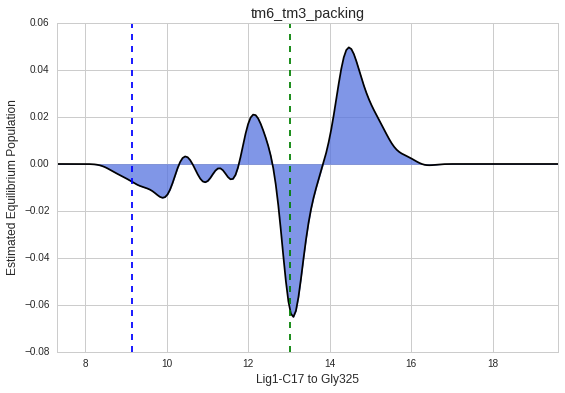

(200,)
(200,)
(200,)


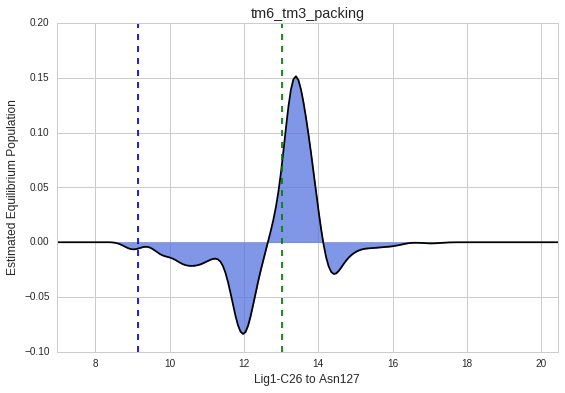

(200,)
(200,)
(200,)


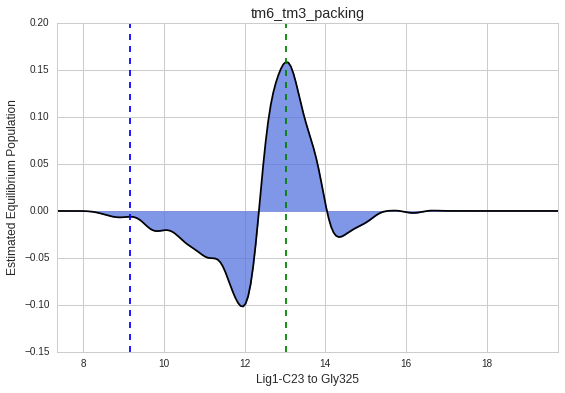

(200,)
(200,)
(200,)


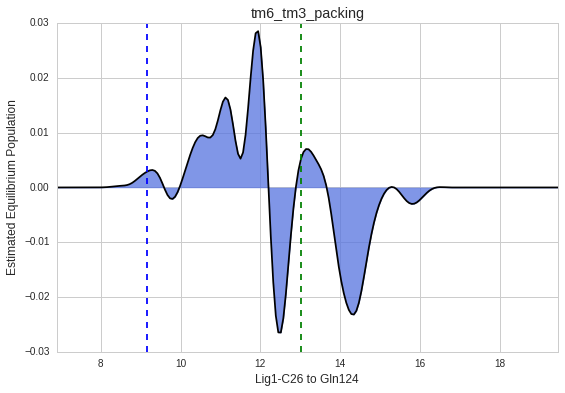

(200,)
(200,)
(200,)


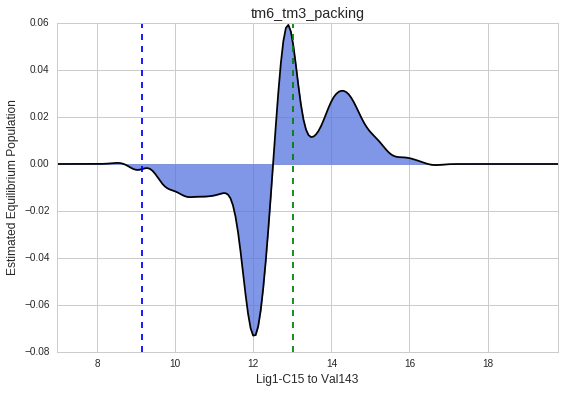

(200,)
(200,)
(200,)


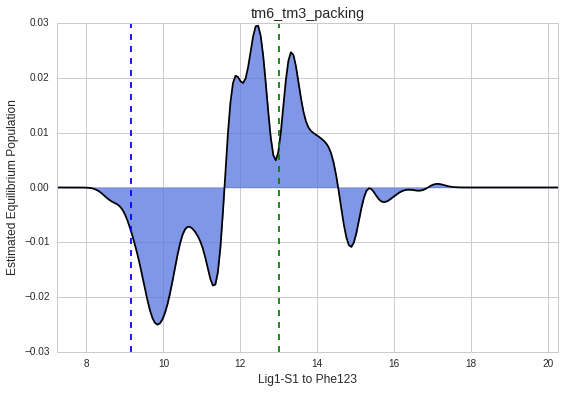

(200,)
(200,)
(200,)


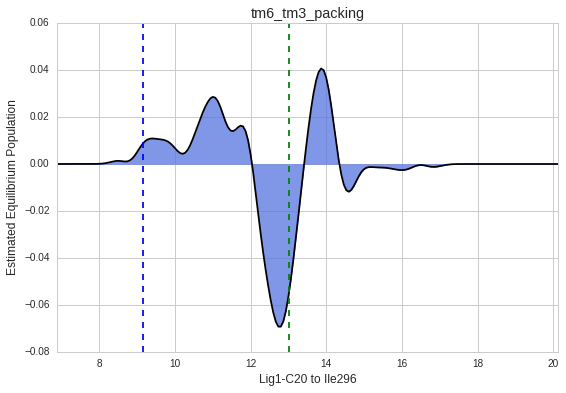

(200,)
(200,)
(200,)


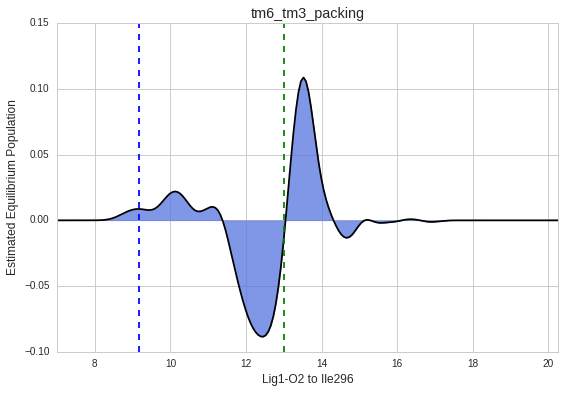

(200,)
(200,)
(200,)


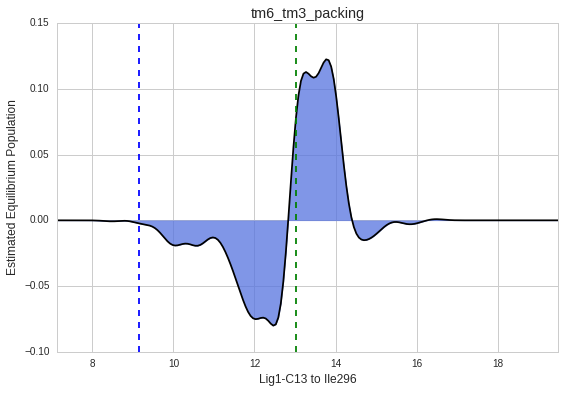

(200,)
(200,)
(200,)


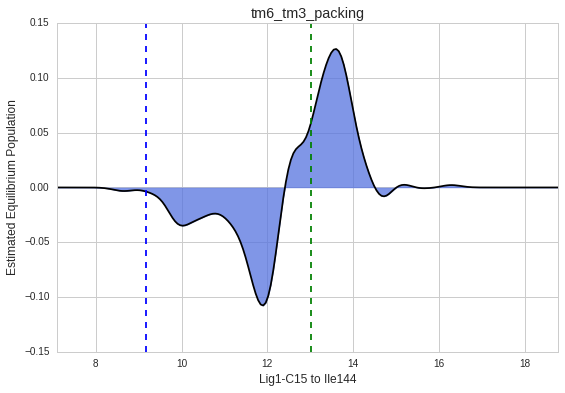

(200,)
(200,)
(200,)


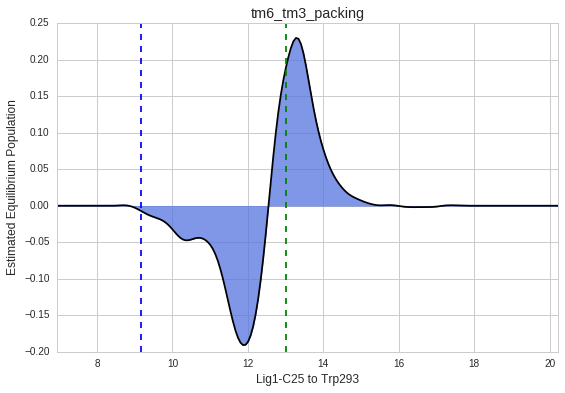

(200,)
(200,)
(200,)


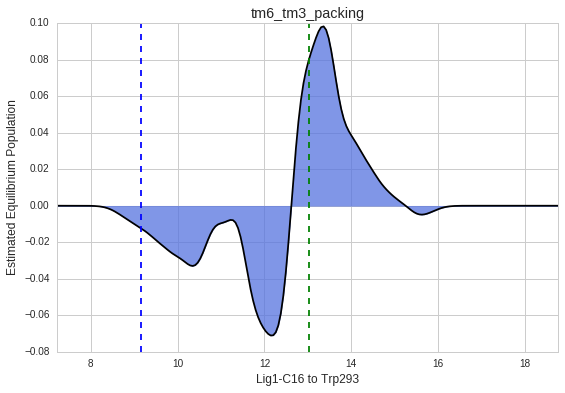

(200,)
(200,)
(200,)


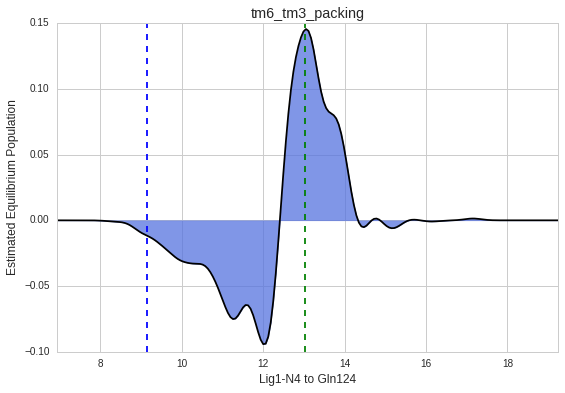

(200,)
(200,)
(200,)


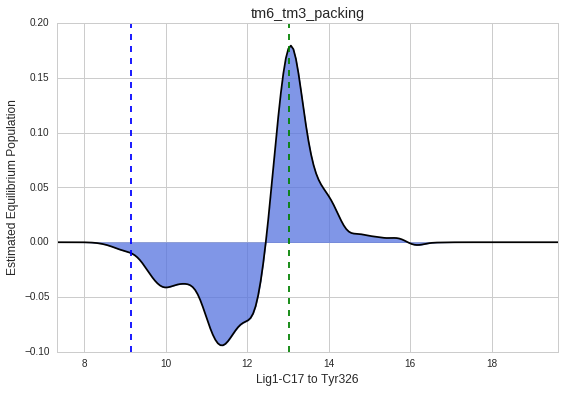

(200,)
(200,)
(200,)


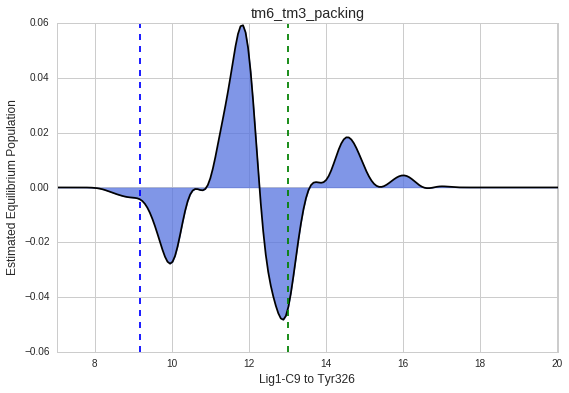

(200,)
(200,)
(200,)


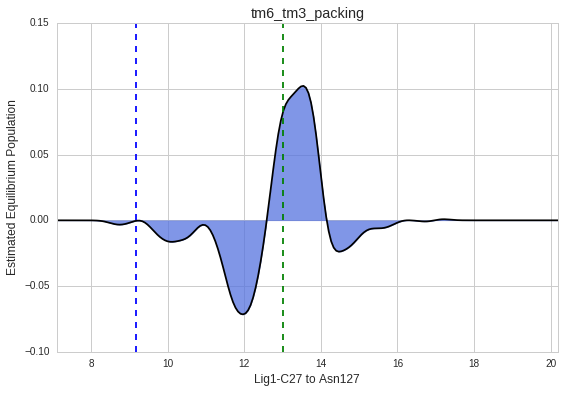

(200,)
(200,)
(200,)


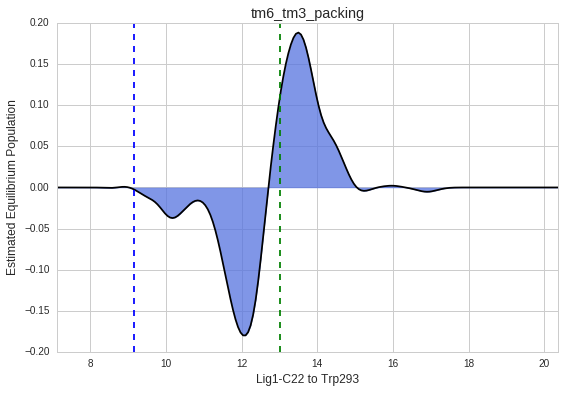

(200,)
(200,)
(200,)


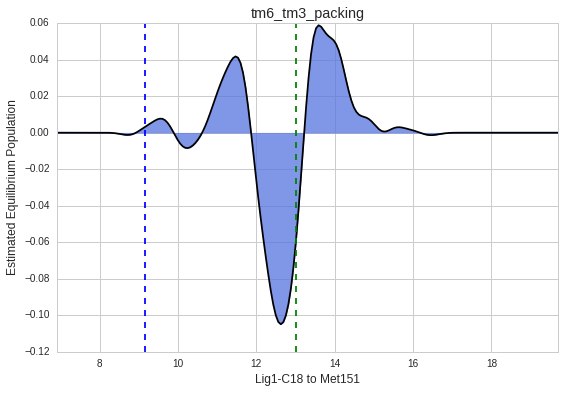

(200,)
(200,)
(200,)


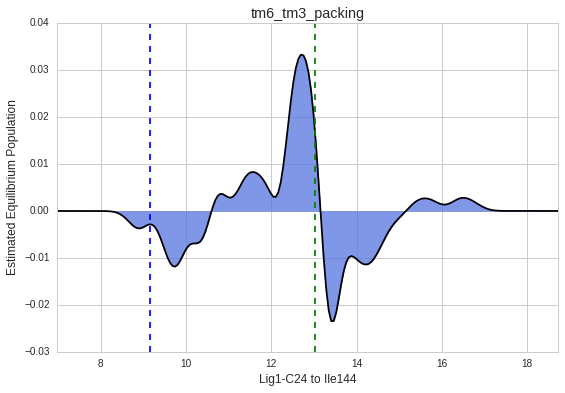

(200,)
(200,)
(200,)


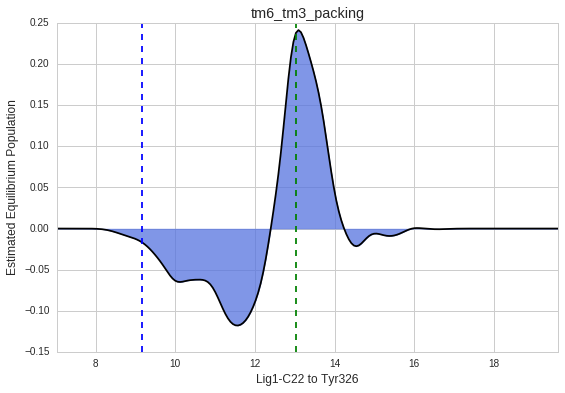

(200,)
(200,)
(200,)


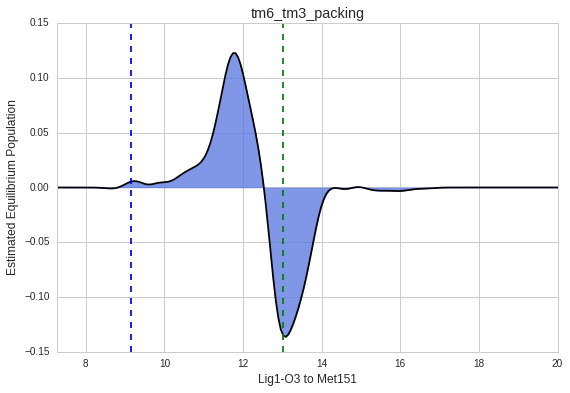

(200,)
(200,)
(200,)


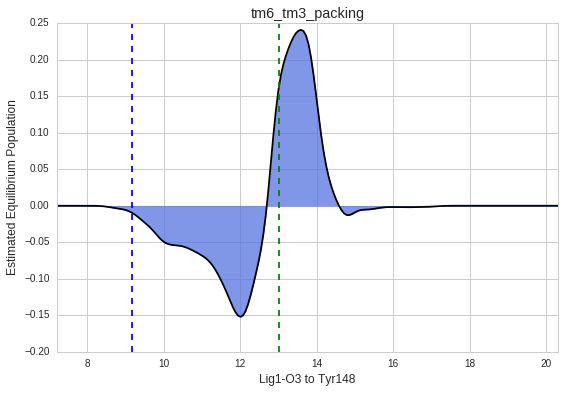

(200,)
(200,)
(200,)


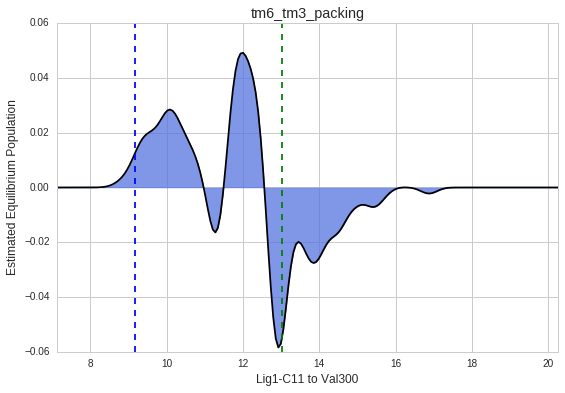

(200,)
(200,)
(200,)


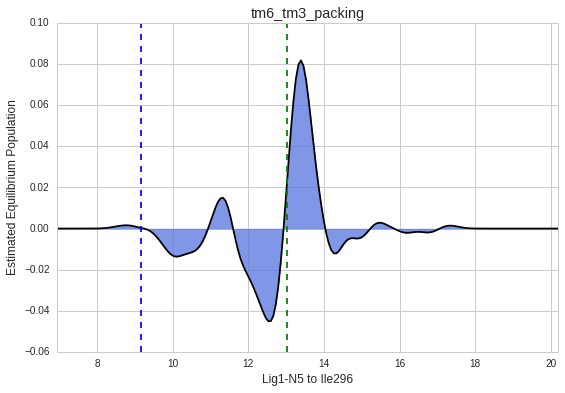

(200,)
(200,)
(200,)


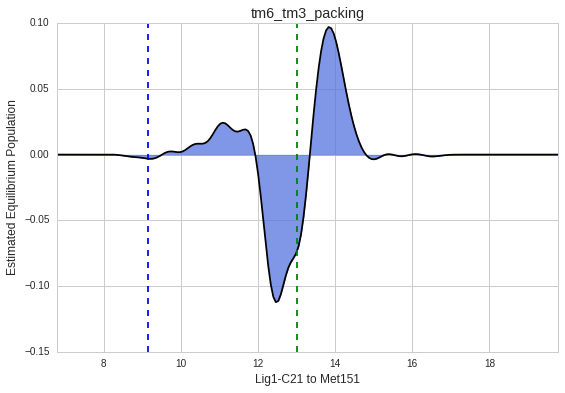

(200,)
(200,)
(200,)


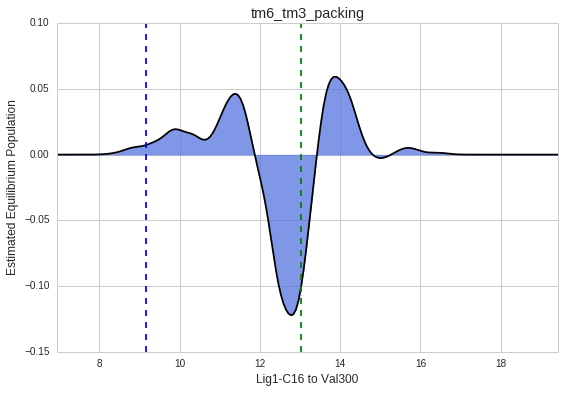

(200,)
(200,)
(200,)


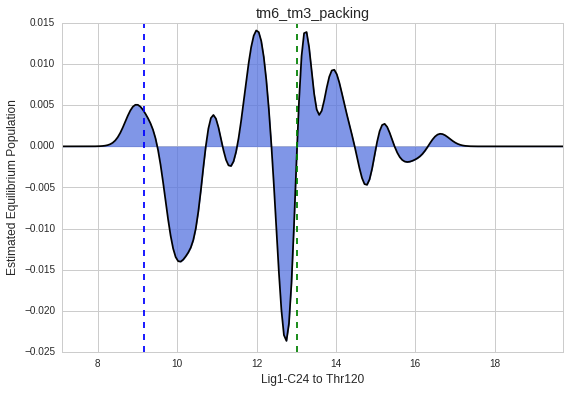

(200,)
(200,)
(200,)


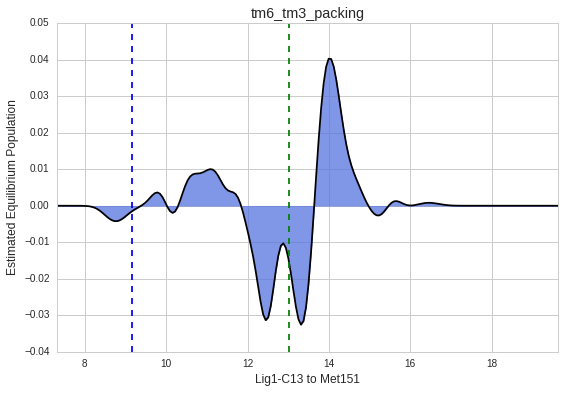

(200,)
(200,)
(200,)


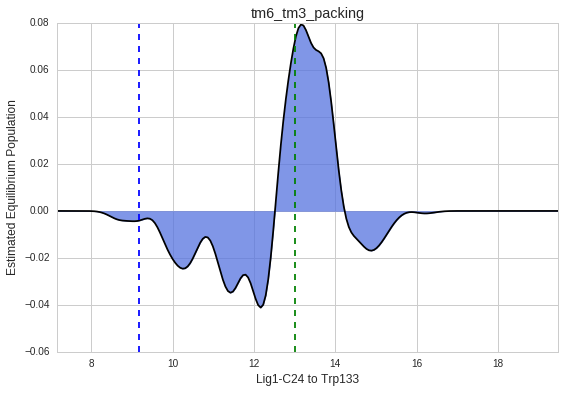

(200,)
(200,)
(200,)


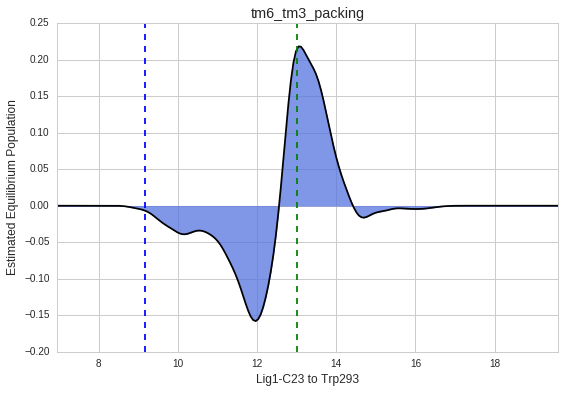

(200,)
(200,)
(200,)


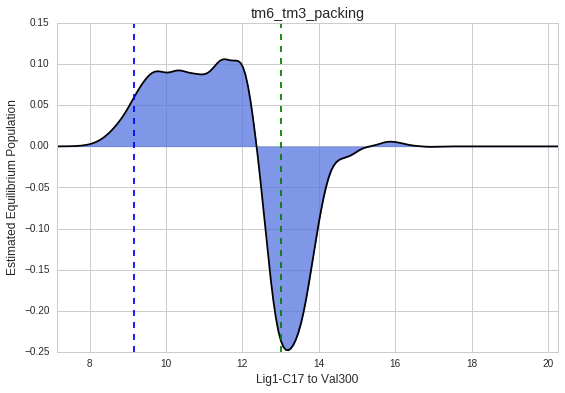

(200,)
(200,)
(200,)


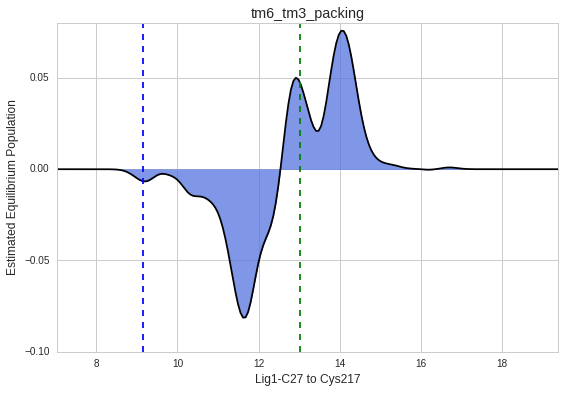

(200,)
(200,)
(200,)


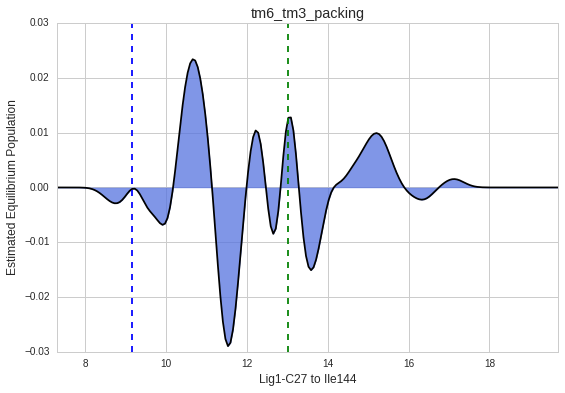

(200,)
(200,)
(200,)


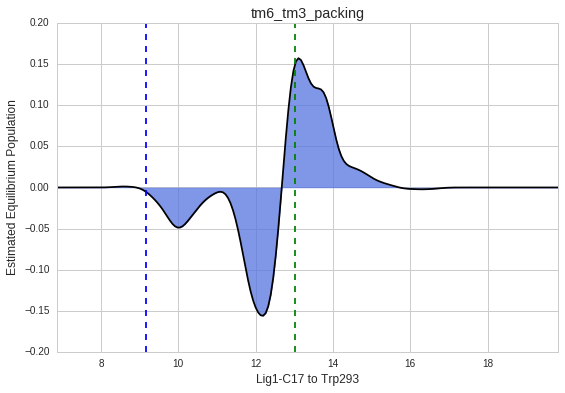

(200,)
(200,)
(200,)


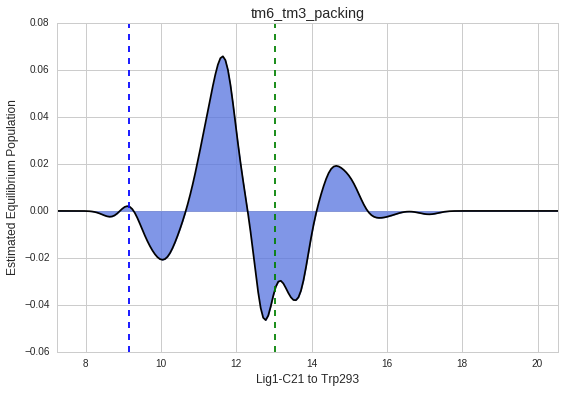

(200,)
(200,)
(200,)


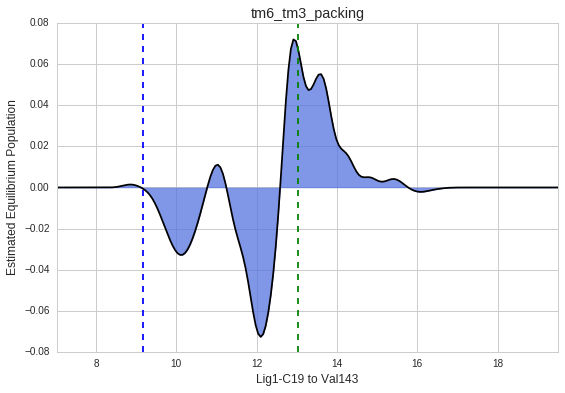

(200,)
(200,)
(200,)


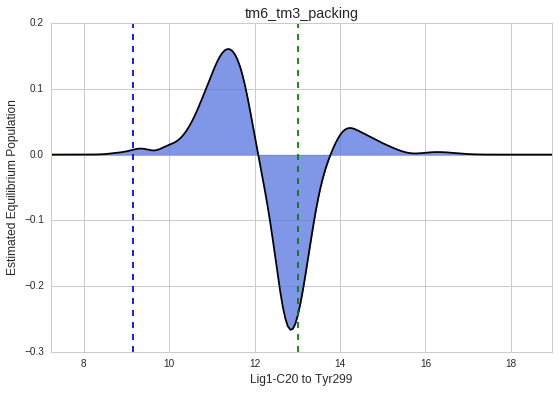

(200,)
(200,)
(200,)


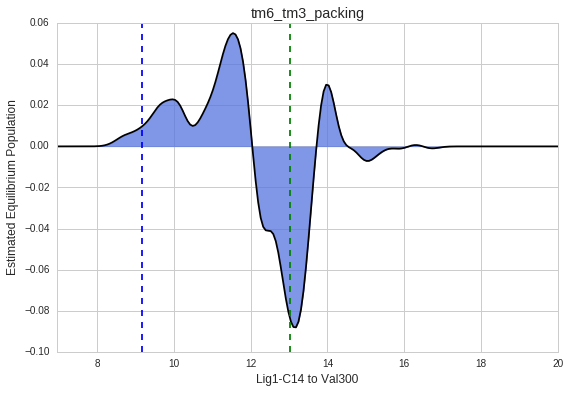

(200,)
(200,)
(200,)


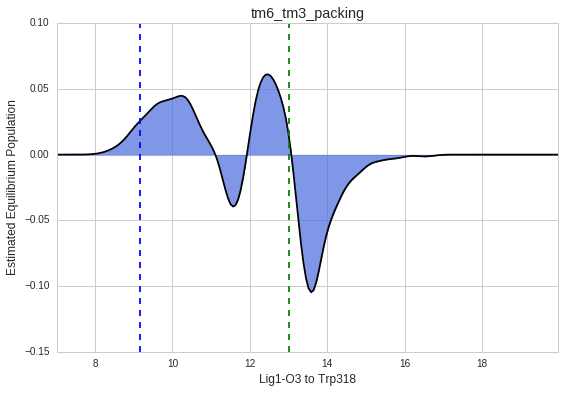

(200,)
(200,)
(200,)


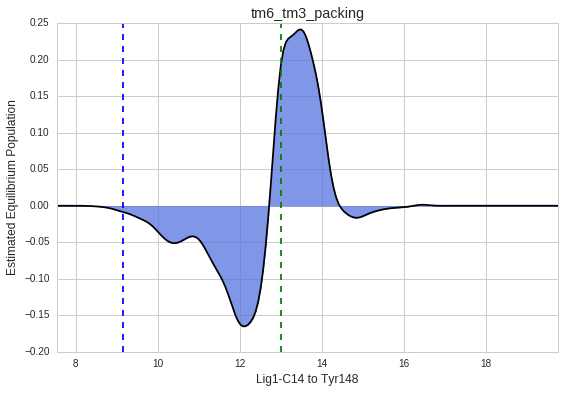

(200,)
(200,)
(200,)


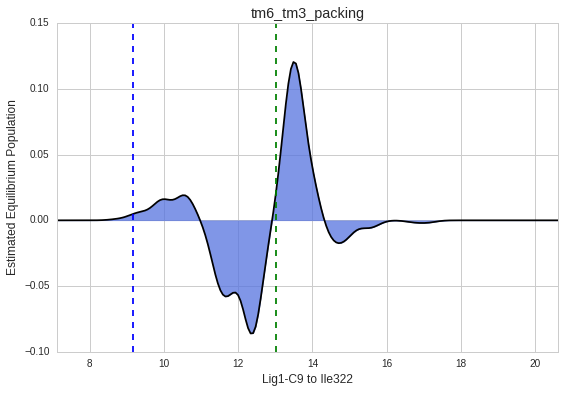

(200,)
(200,)
(200,)


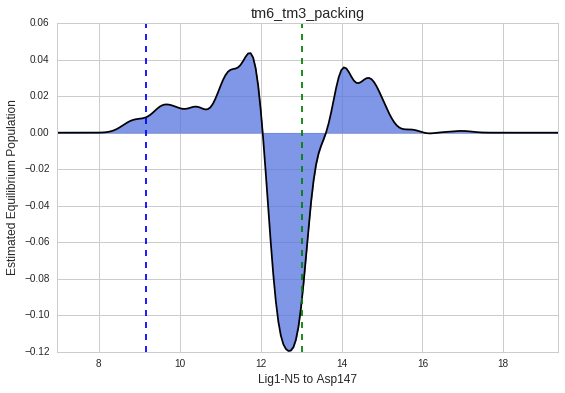

(200,)
(200,)
(200,)


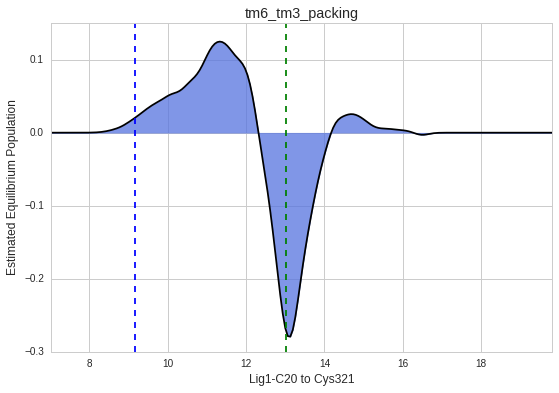

(200,)
(200,)
(200,)


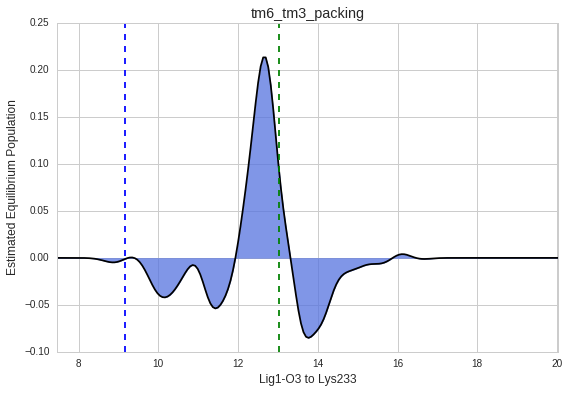

(200,)
(200,)
(200,)


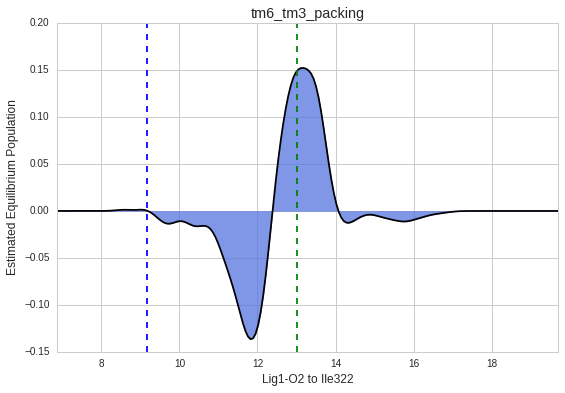

(200,)
(200,)
(200,)


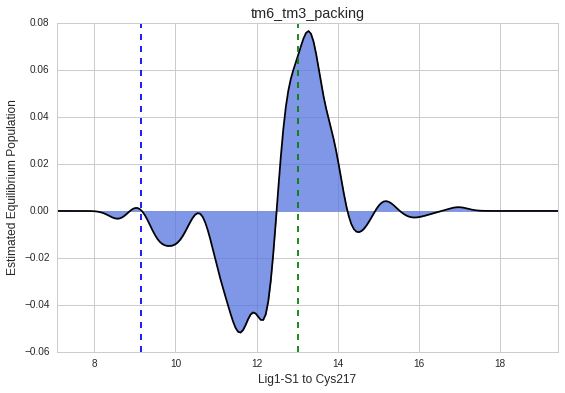

(200,)
(200,)
(200,)


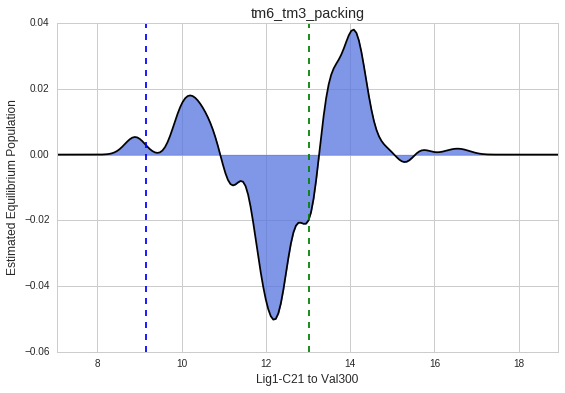

(200,)
(200,)
(200,)


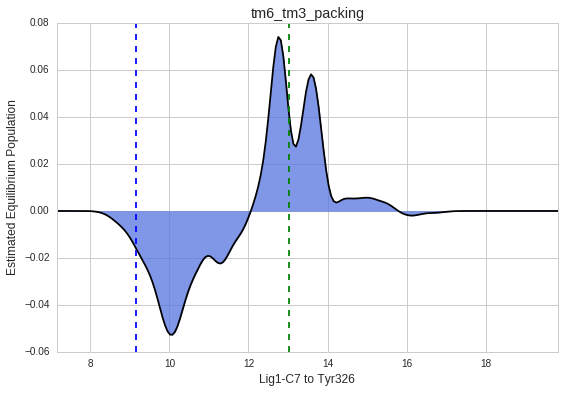

(200,)
(200,)
(200,)


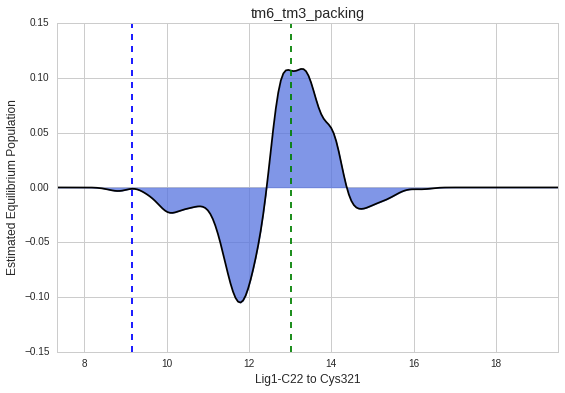

(200,)
(200,)
(200,)


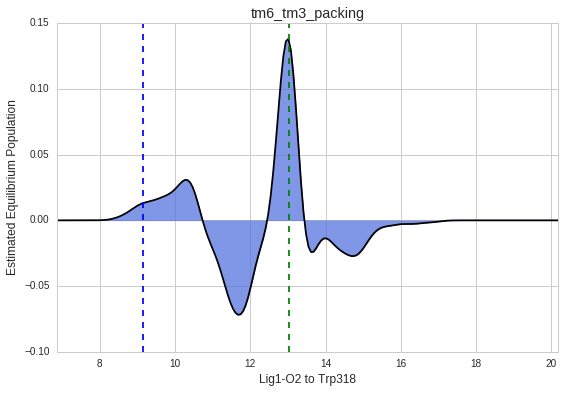

(200,)
(200,)
(200,)


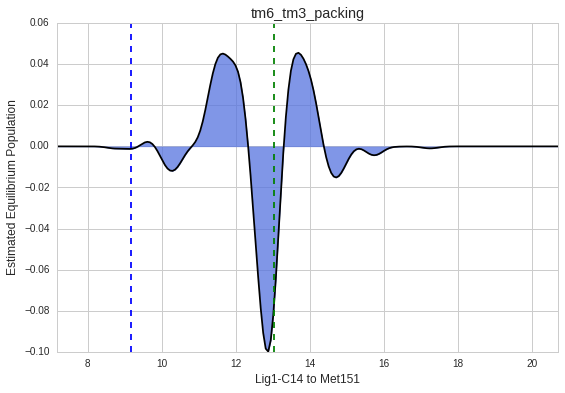

(200,)
(200,)
(200,)


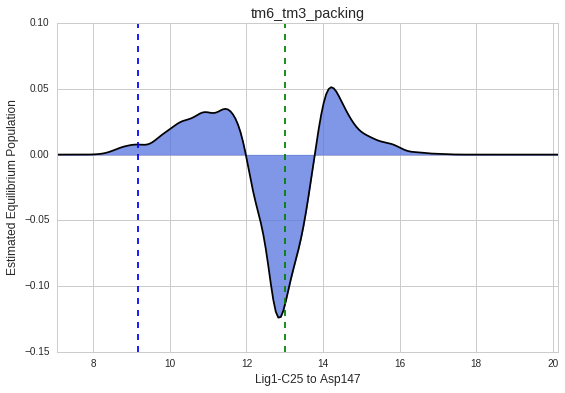

(200,)
(200,)
(200,)


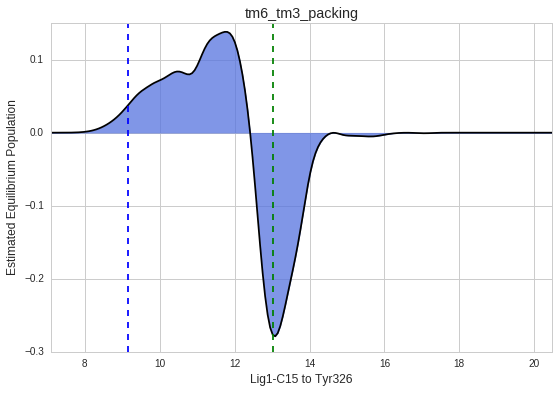

(200,)
(200,)
(200,)


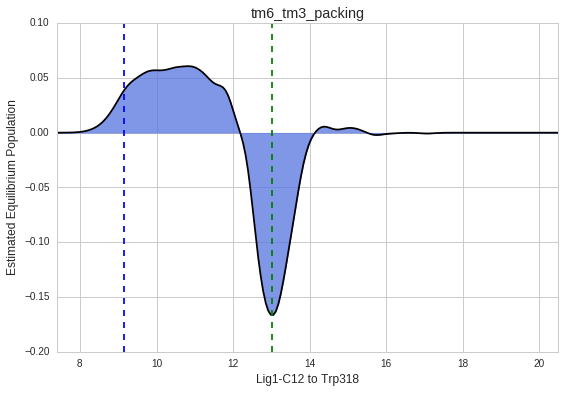

(200,)
(200,)
(200,)


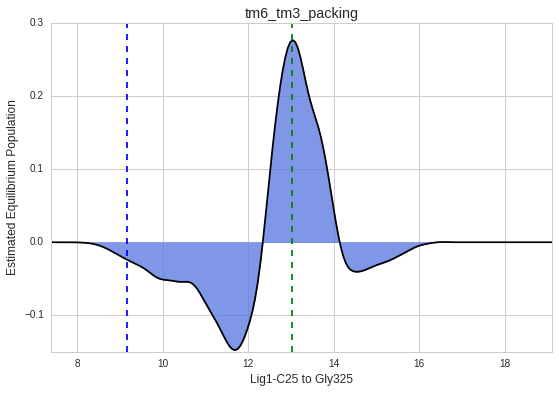

(200,)
(200,)
(200,)


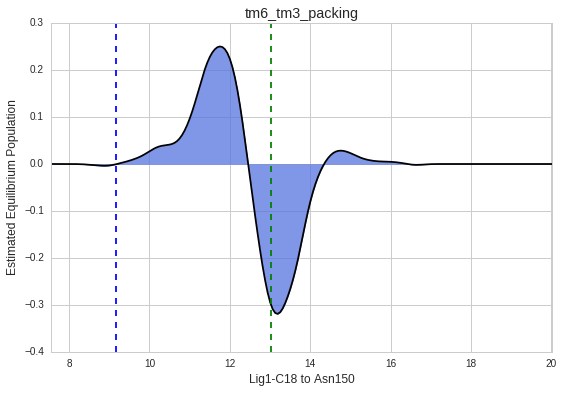

(200,)
(200,)
(200,)


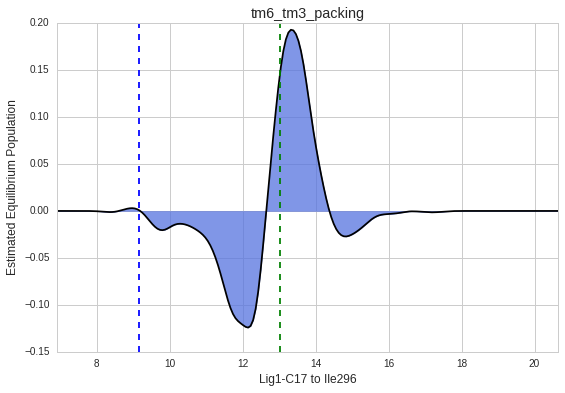

(200,)
(200,)
(200,)


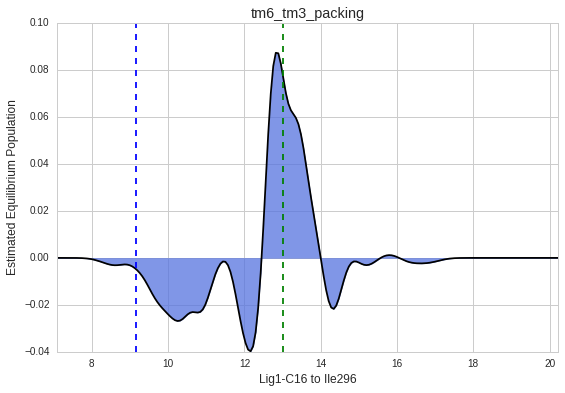

(200,)
(200,)
(200,)


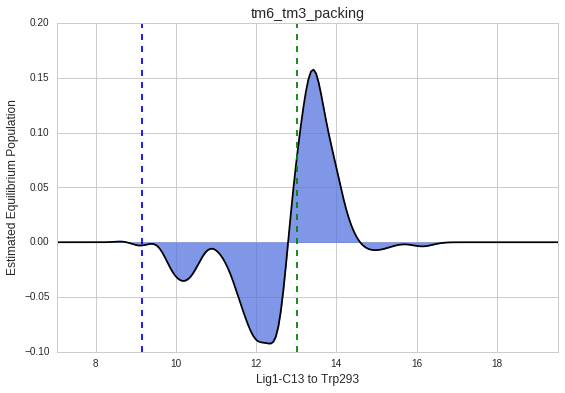

(200,)
(200,)
(200,)


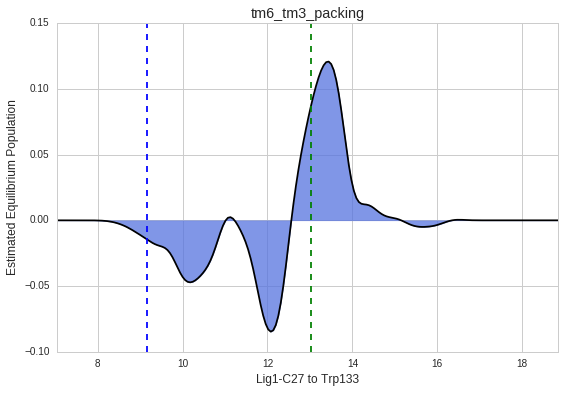

(200,)
(200,)
(200,)


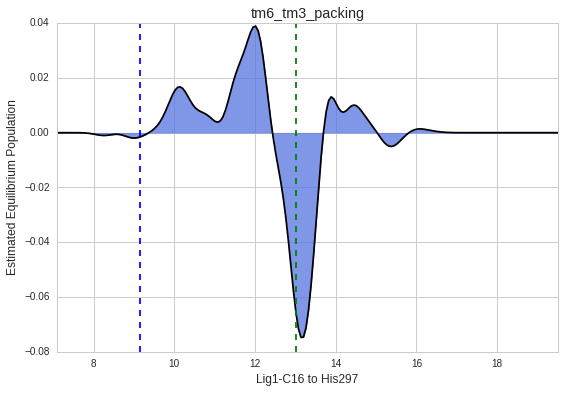

(200,)
(200,)
(200,)


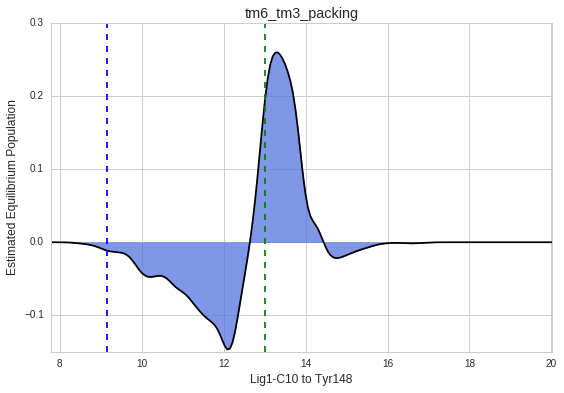

(200,)
(200,)
(200,)


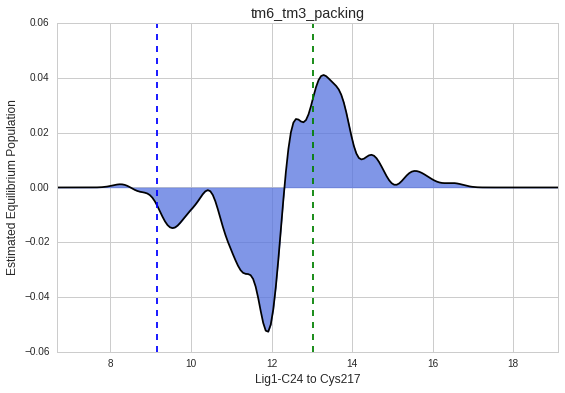

(200,)
(200,)
(200,)


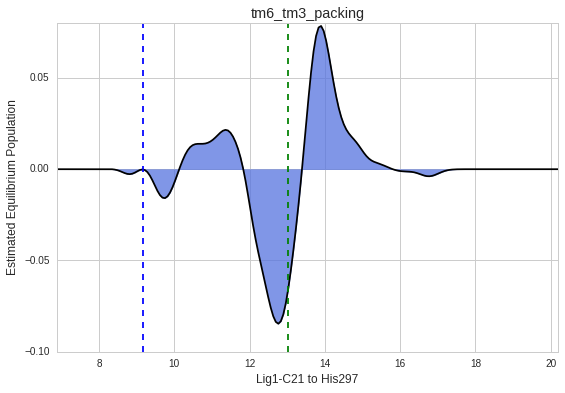

(200,)
(200,)
(200,)


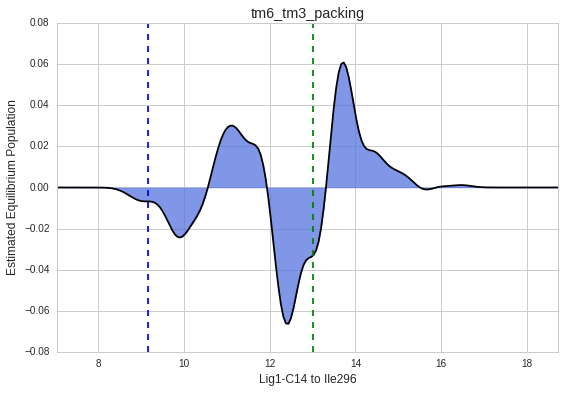

(200,)
(200,)
(200,)


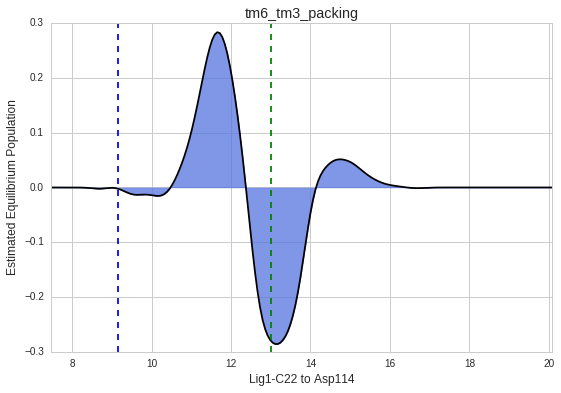

(200,)
(200,)
(200,)


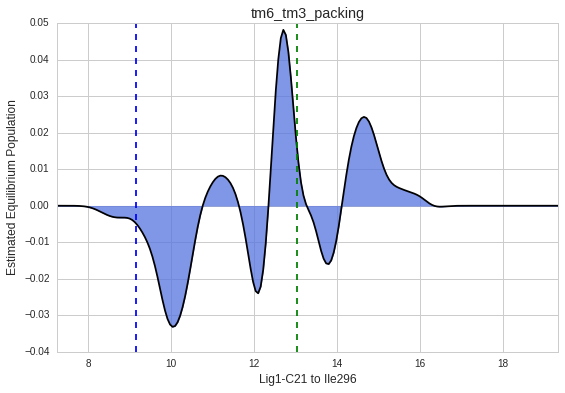

(200,)
(200,)
(200,)


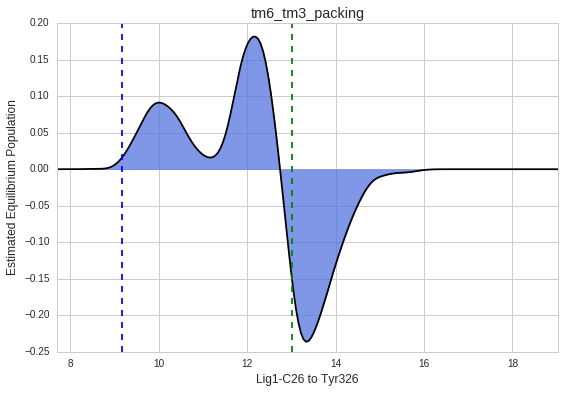

(200,)
(200,)
(200,)


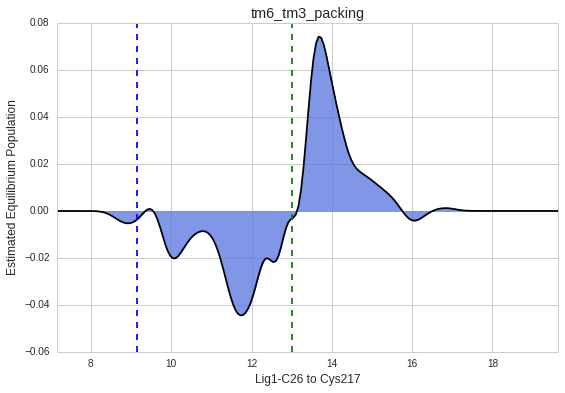

(200,)
(200,)
(200,)


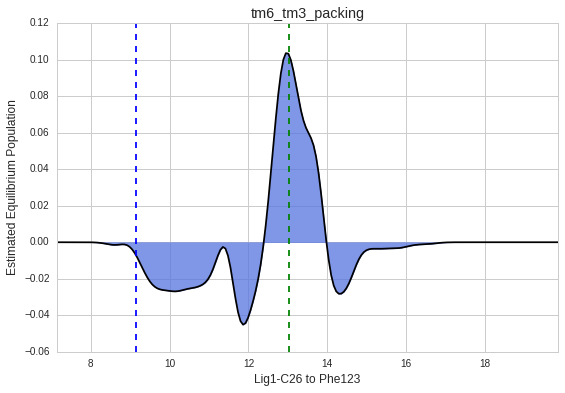

(200,)
(200,)
(200,)


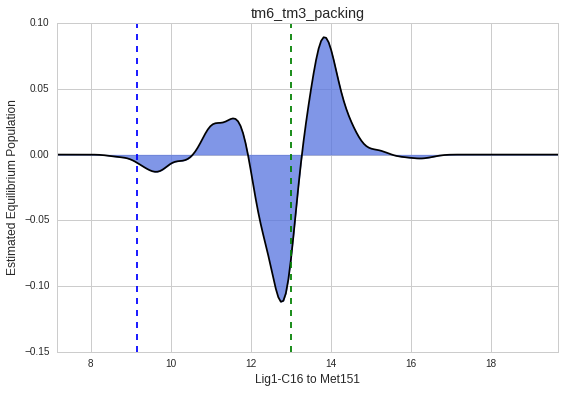

(200,)
(200,)
(200,)


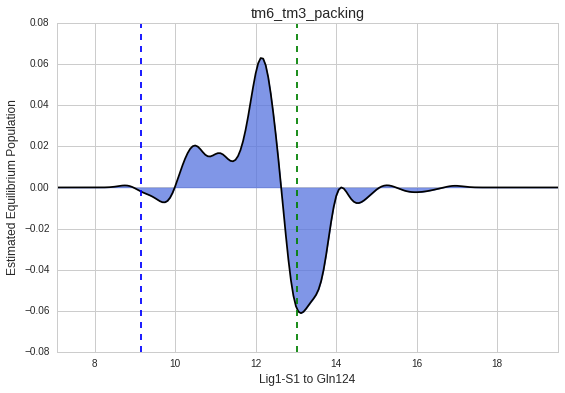

(200,)
(200,)
(200,)


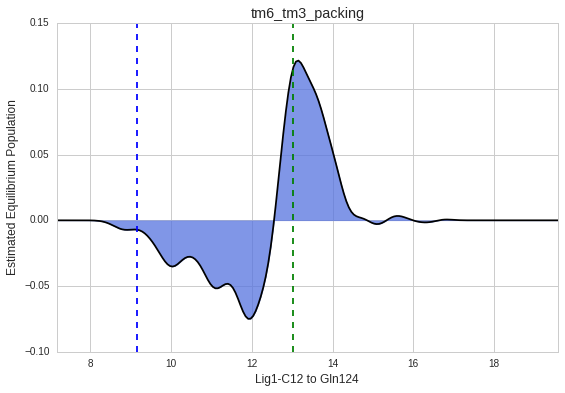

(200,)
(200,)
(200,)


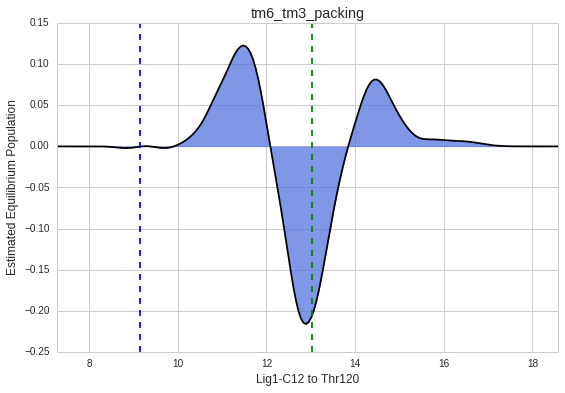

(200,)
(200,)
(200,)


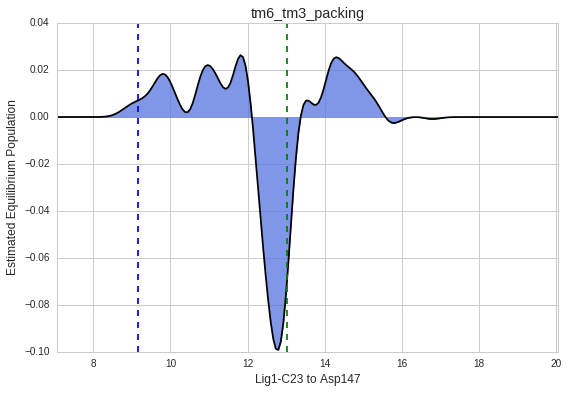

(200,)
(200,)
(200,)


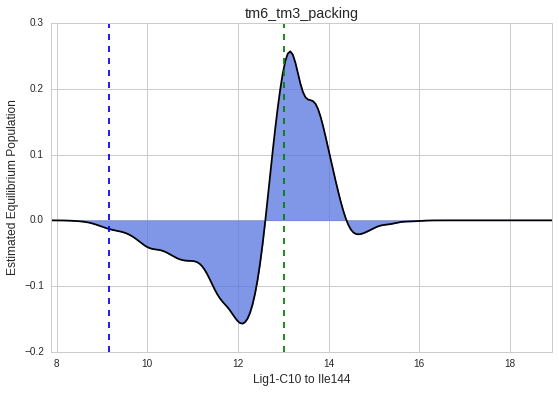

(200,)
(200,)
(200,)


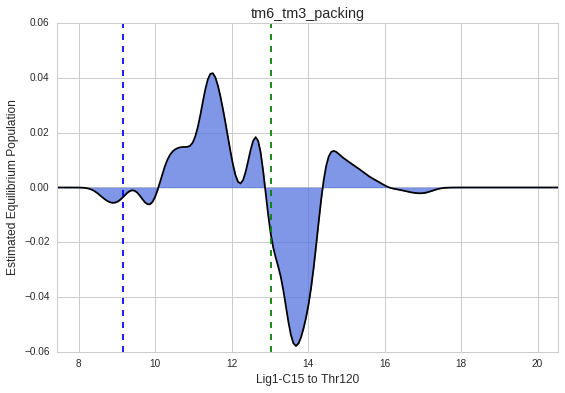

(200,)
(200,)
(200,)


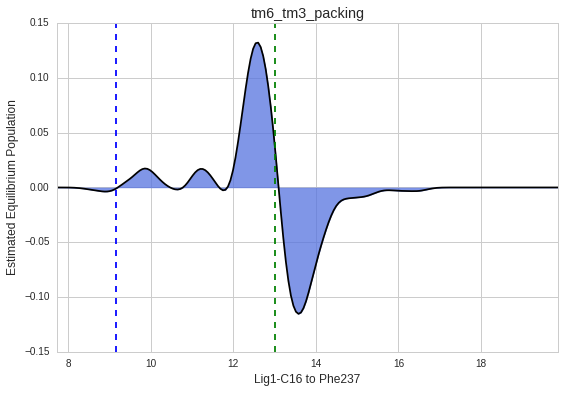

(200,)
(200,)
(200,)


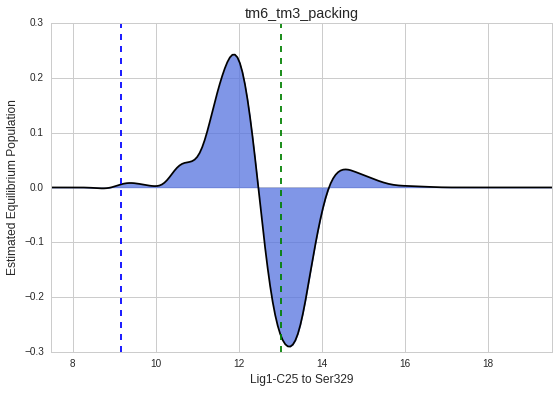

In [136]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

plt.clf()
name_j = "tm6_tm3_packing"
for i in range(1,100):
    name_i = get_ori_feature_name(path_df.feature.values[i]).replace("SUF", "Lig1")
    if "Lig1" not in name_i: continue
    data_i = all_features_conc.loc[all_features_conc[name_i] < 5.][name_j].values[::100]
    data_j = all_features_conc.loc[all_features_conc[name_i] > 5.][name_j].values[::100]
    compute_and_plot_kde_difference(data_i, data_j, name_j, name_i,
                                    "", custom_bounds=None,
                                    custom_y_bounds=None,
                                    crystal_values=ref_features[name_j].values,
                                    show_plot=True)
    """
    try:
        name = path_df.feature.values[i].replace("SUF", "Lig1").replace(" < 5.000000", "")
        plt.scatter(all_features_conc[name].iloc[::200], all_features_conc["PHE289 to PRO244"].iloc[::200])
    except:
        name= path_df.feature.values[i]
        plt.scatter(all_features_conc[name].iloc[::200], all_features_conc["PHE289 to PRO244"].iloc[::200])
    plt.title(name)
    plt.show()
    """
    plt.show()

In [81]:
df = pd.DataFrame([(key, value['weight']) for key, value in top_causality_graph['rmsd_npxxy_inactive < 0.413002'].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
#df = pd.DataFrame([(key, value['weight']) for key, value in top_causality_graph["LYS233_CA to LYS303_CA < 9.207879"].items()], columns=['edge', 'weight']).sort('weight', inplace=False,ascending=False)
df.loc[df.edge.str.contains("SUF")]

NameError: name 'top_causality_graph' is not defined

In [ ]:
features_eq.loc[(features_eq["tm6_tm3_packing"] < 10.5) & (features_eq["rmsd_npxxy_inactive"] < 0.35)].shape[0]

In [ ]:
all_features_conc.loc[(all_features_conc["tm6_tm3_packing"] < 10.5) & (all_features_conc["rmsd_npxxy_inactive"] < 0.35)].shape

In [ ]:
plt.hist()

In [ ]:
plt.scatter(all_features_conc["Lig1-O3 to Asp147"].values[::500], all_features_conc["rmsd_npxxy_active"].values[::500])

In [ ]:
subgraph_file = "%s/subgraph_tm6_tm3_target.graphml" %analysis_dir
extract_paths_from_graph(top_causality_graph, path_df, importance_cutoff=1e-3, graph_file=subgraph_file)

In [ ]:
reload(matplotlib)
r2_scores_df = pd.Series(scores, index=y.columns).sort(ascending=False, inplace=False)
r2_scores_df = r2_scores_df.loc[r2_scores_df > 0.]
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title, figsize=(5,10))
plt.xlabel("Average Test ROC AUC")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_oneshot_%s.pdf" %(analysis_dir, title))
plt.show()

In [ ]:
r2_scores_df

In [ ]:
"%s/all_features_oneshot_%s.pdf" %(analysis_dir, title)

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

In [ ]:
if not os.path.exists("%s/all_features_multionehot_rfr_scores.h5" %analysis_dir):
    scores, importances = compute_rf_matrix(x.values, y_classified.values, n_trees=500, max_depth=3, n_folds=5, task="regression")
    verbosedump(scores, "%s/all_features_multionehot_classified_rfr_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/all_features_multionehot_classified_rfr_importances.h5" %analysis_dir)
else:
    scores = compat_verboseload("%s/all_features_multionehot_classified_rfr_scores.h5" %analysis_dir)
    importances = compat_verboseload("%s/all_features_multionehot_classified_rfr_importances.h5" %analysis_dir)

#if not os.path.exists("%s/all_features_rfr_r2_scores.h5" %analysis_dir):
#    print("hi")
#r2_scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
#verbosedump(r2_scores, "%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#verbosedump(importances, "%s/all_features_rfr_importances.h5" %analysis_dir)
#else:
#r2_scores = compat_verboseload("%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#importances = compat_verboseload("%s/all_features_rfr_importances.h5" %analysis_dir)

In [ ]:
scores_df = pd.Series(scores, index=y.columns)
scores_df.sort(inplace=False)

In [ ]:
#pearson_matrix = compute_pearson_matrix(x.values, y.values)
#pearson_df = pd.DataFrame(pearson_matrix, columns=y.columns, index=x.columns)
pearson_df["tm6_tm3_packing"].abs().sort(inplace=False)

In [ ]:
importances_df = pd.DataFrame(importances, columns=y_classified.columns, index=x.columns)
#importances_df["mOR tIC.5"].loc[[n for n in importances_df.index.values.tolist()]].abs().sort(inplace=False, ascending=False)
#importances_df["PHE289 to ASN150"].abs().sort(inplace=False, ascending=False).iloc[:100]
df = importances_df["MET281_CA to MET161_CA"].abs().sort(inplace=False, ascending=False)
df.loc[[n for n in df.index.values.tolist() if "<" in n]]


In [ ]:
plt.clf()
plt.hist(pd.concat(all_traj_features,axis=0)["PHE289 to ASN150"].values, bins=50)
plt.show()

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
feature = "TYR336 to PHE289"
plt.clf()
#for i in range(0,100):
#    if "Tyr326" in df.index.values[i]:
data_i = y.loc[features_eq["Lig900-N1 to Tyr326"] < 5.][feature].values
data_j = y.loc[features_eq["Lig900-N1 to Tyr326"] > 5.][feature].values
        #data_i = y.loc[x[df.index.values[i]] == 1.][feature].values
        #data_j = y.loc[x[df.index.values[i]] == 0.][feature].values
        #if len(np.where(data > 10.)[0]) < 5*len(np.where(data < 10.)[0]): continue
        #if len(np.where(data > 10.)[0]) < 150: continue
title_i = df.index.values[i].replace("Lig900", "suf")
title_j = "Not %s" %df.index.values[i].replace("Lig900", "suf")
        #compute_and_plot_single_kde(data_i, title_i, 
        #                            "Phe289 to Asn150 Distance, Angstroms", "%s/%s.pdf" %(analysis_dir,title_i), custom_bounds=[5,16], custom_y_bounds=[0,.6])
        #compute_and_plot_single_kde(data_j, title_j, 
        #                            "Phe289 to Asn150 Distance, Angstroms", "%s/%s.pdf" %(analysis_dir,title_j), custom_bounds=[5,16], custom_y_bounds=[0,.6])
compute_and_plot_kde_difference(data_i, data_j, title_i, "%s Distance, Angstroms" %feature, "%s/%s_difference.pdf" %(analysis_dir,title_i), custom_bounds=[5,16], custom_y_bounds=[-.4,.4])
        

In [ ]:
y_classified["tm6_tm3_packing"]

In [ ]:
plt.scatter(features_eq["Lig900-N1 to Tyr326"].iloc[::10], features_eq["tm6_tm3_packing"].iloc[::10])
plt.show()

In [ ]:
data_i

In [ ]:
analysis_dir

In [ ]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()

#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
#for j in range(0, importances_scaled.shape[1]):
#    importances_scaled[:,j] *= r2_scores[j]

#responses_to_keep = np.where(np.array(r2_scores) > 0.5)[0]
#importances_scaled = importances_scaled[:,responses_to_keep]
#predictors_to_keep = list(set(np.where(importances_scaled > 0.03)[0].tolist()))
#print(responses_to_keep)
#print(predictors_to_keep)
#importances_scaled = importances_scaled[predictors_to_keep,:]
#print(len(responses_to_keep))

row_labels = ["suf tIC.%d" %i for i in range(1, n_components+1)]
column_labels = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
#row_labels = x.columns.values[predictors_to_keep]
#column_labels = y.columns.values[responses_to_keep]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/all_features_rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None, xtick_labelsize=8, ytick_labelsize=8)
plt.show()

"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/suf_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/suf_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [ ]:
from jointplot_d3 import *
titles_j = [f for f in features_eq.columns.values if "Lig" in f and "Tyr326" in f]
print(titles_j)
jointplots(features_eq[titles_j].values, analysis_dir, titles=titles_j,
                           main = "mOR MSM", refcoords=None, refcoords_j=None, axes=None,
                               data_j=features_eq[["tm6_tm3_packing"]].values, titles_j=["tm6_tm3_packing"], reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

r2_scores

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=2, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["suf tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_suf_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_j, tic_save_dir, titles=lig_features+all_lig_features,
                           main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                               data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=5, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
protein_ligand_msm_featurized.columns.values.tolist()

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, features_i, features_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=100, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            
            if "PHE289 to ASN150" not in str(features_i[prot_idx]): continue
            
            all_prot_features = [str(features_i[prot_idx])]
            all_lig_features = [str(features_j[lig_idx]) for lig_idx in lig_order[:n_lig_tICs]]
            

            features = []
            prot_features = []
            lig_features = []

            if make_jointplots:
                print("Creating joint deltaG plots.")
                data_i = features_eq[prot_features+all_prot_features].values
                print(data_i.shape)
                data_j = features_eq[lig_features+all_lig_features].values
                print(data_j.shape)

                if ref_df is not None:
                    refcoords = ref_df[prot_features+all_prot_features].values
                    print(refcoords.shape)
                    refcoords_j = ref_df[lig_features+all_lig_features].values
                    print(refcoords_j.shape)
                    combined_refcoords = np.hstack([refcoords, refcoords_j])
                    custom_refcoords = ref_df[custom_features[0]].values
                else:
                    refcoords = None
                    refcoords_j = None
                    combined_refcoords = None
                    custom_refcoords = None

                jointplots(data_i, save_dir, titles=prot_features+all_prot_features,
                       main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8, custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(data_j, save_dir, titles=lig_features + all_lig_features, 
                       main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                           data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(np.hstack([data_i, data_j]), save_dir, titles=prot_features+all_prot_features+lig_features+all_lig_features,
                       main = "mOR MSM", refcoords=combined_refcoords, refcoords_j=custom_refcoords, axes=None,
                           data_j=features_eq[custom_features[0]].values, titles_j=custom_features[0], reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      y.columns, x.columns, n_combs=5,
                                      r2s = np.array(scores), subsample=1, smoothing=100,
                                      n_tICs=20, max_features=1,
                                      #custom_features = None,
                                      custom_features=[[], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
jointplots_dir

In [ ]:
names

In [ ]:
features_eq[ 'Lig1-C13 to Lys233']

In [ ]:
tpt_paths_features

In [65]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None):

    for t, prot_pair in enumerate(prot_pairs):
        if t == n_tICs:
            break
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j = None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [0, 1, 3, 4]
prot_pairs = []
for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
        prot_pairs.append((tics_to_examine[j], tics_to_examine[i]))
print(prot_pairs)

prot_pairs += [(3, 6), (3, 8), (3,9)]
#make_msm_features_plots_single(importances, protein_ligand_msm_featurized,
#                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
#                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
#                                     n_tICs=10, max_features=1,
#                                      custom_features = None,
#                                     custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
#                                     make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir,
#                                     prot_pairs=prot_pairs)
#                                     #tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

[(0, 1), (1, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 3), (3, 1), (1, 4), (4, 1), (3, 4), (4, 3)]


In [133]:
suf_pp_all_features, suf_pp_tIC_features = interpret_tIC_components(suf_pp_projection_operator_dir, suf_pp_tic_components_dir, suf_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(10, 5)
residue_importances_df.shape
(12, 2)
             feature_name      res_i      res_j  importance  \
7  Lys233_Ca To Lys303_Ca  Lys233_Ca  Lys303_Ca   -0.380112   
1  Ala304_Ca To Asn230_Ca  Ala304_Ca  Asn230_Ca    0.325877   
2  Ala304_Ca To Lys233_Ca  Ala304_Ca  Lys233_Ca    0.306402   
6  Ile308_Ca To Tyr299_Ca  Ile308_Ca  Tyr299_Ca    0.290794   
5  Ile308_Ca To Trp318_Ca  Ile308_Ca  Trp318_Ca   -0.284625   
3  Ala304_Ca To Tyr299_Ca  Ala304_Ca  Tyr299_Ca   -0.282444   
0        Leu339 To Val334     Leu339     Val334    0.251023   
9  Val236_Ca To Val300_Ca  Val236_Ca  Val300_Ca    0.222654   
4  Ile301_Ca To Val236_Ca  Ile301_Ca  Val236_Ca   -0.214483   
8  Lys303_Ca To Trp318_Ca  Lys303_Ca  Trp318_Ca    0.171570   

                  feature  
7  LYS233_CA to LYS303_CA  
1  ALA304_CA to ASN230_CA  
2  ALA304_CA to LYS233_CA  
6  ILE308_CA to TYR299_CA  
5  ILE308_CA to TRP318_CA  
3  ALA304_CA to TYR299_CA  
0        LEU339 t

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/interpret_tICs.py:97: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


             residue  importance
Asn230_Ca  Asn230_Ca    0.325877
Ala304_Ca  Ala304_Ca    0.323930
Lys233_Ca  Lys233_Ca    0.272077
Tyr299_Ca  Tyr299_Ca    0.262132
Ile308_Ca  Ile308_Ca    0.262023
Val334        Val334    0.251023
Leu339        Leu339    0.251023
Val300_Ca  Val300_Ca    0.222654
Ile301_Ca  Ile301_Ca   -0.214483
Val236_Ca  Val236_Ca    0.200797
Trp318_Ca  Trp318_Ca    0.148760
Lys303_Ca  Lys303_Ca    0.143986
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(8, 5)
residue_importances_df.shape
(16, 2)
             feature_name      res_i      res_j  importance  \
0         Leu88 To Phe338      Leu88     Phe338    0.434772   
2  Ala304_Ca To Asn230_Ca  Ala304_Ca  Asn230_Ca   -0.296001   
4  Leu339_Ca To Val334_Ca  Leu339_Ca  Val334_Ca    0.232692   
6   Phe338_Ca To Phe84_Ca  Phe338_Ca   Phe84_Ca    0.142109   
3  Asn328_Ca To Ile155_Ca  Asn328_Ca  Ile155_Ca    0.110870   
5  Phe289_Ca To Tyr336_Ca  Phe289_Ca  Tyr336_Ca    0.097682   
1  Ala111_Ca To 

In [134]:
suf_pp_tIC_features

[[LEU339 to VAL334,
  ALA304_CA to ASN230_CA,
  ALA304_CA to LYS233_CA,
  ALA304_CA to TYR299_CA,
  ILE301_CA to VAL236_CA,
  ILE308_CA to TRP318_CA,
  ILE308_CA to TYR299_CA,
  LYS233_CA to LYS303_CA,
  LYS303_CA to TRP318_CA,
  VAL236_CA to VAL300_CA],
 [LEU88 to PHE338,
  ALA111_CA to ASN332_CA,
  ALA304_CA to ASN230_CA,
  ASN328_CA to ILE155_CA,
  LEU339_CA to VAL334_CA,
  PHE289_CA to TYR336_CA,
  PHE338_CA to PHE84_CA,
  SER329_CA to VAL81_CA],
 [ALA304 to ASN230,
  ALA304 to LYS233,
  LEU305 to VAL300,
  LYS233 to VAL300,
  ALA304_CA to GLU229_CA,
  ALA304_CA to TYR299_CA,
  ARG280_CA to PHE338_CA,
  ILE301_CA to PHE237_CA,
  ILE301_CA to VAL236_CA,
  LEU232_CA to PHE237_CA,
  LYS233_CA to LYS303_CA,
  LYS233_CA to VAL300_CA,
  PRO333_CA to VAL81_CA,
  TYR336_CA to VAL285_CA,
  VAL236_CA to VAL300_CA],
 [ASP147 to TYR326,
  CYS159 to TYR336,
  CYS79 to TYR326,
  GLY82 to TYR326,
  ILE71 to TYR128,
  PHE289 to TYR336,
  ARG277_CA to ASP340_CA,
  ARG280_CA to GLU341_CA,
  ASN86_CA

In [157]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(plmf, top_features_per_tIC_i, n_combs=3, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None, alt_features_eq=None, worker_pool=None):

    for t, prot_pair in enumerate(prot_pairs):
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features_i].values, alt_features_eq[features_i].values]))
            custom_lims_j = custom_lim_finder(np.vstack([features_eq[features_j].values, alt_features_eq[features_j].values]))
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=worker_pool, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j, remake=True)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

suf_jointplots_refcoords_dir = "%s/suf_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(suf_jointplots_refcoords_dir):
    os.makedirs(suf_jointplots_refcoords_dir)
    
apo_jointplots_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [0, 1, 3, 4]
prot_pairs = [(0,3), (3,4), (3, 6), (3, 8), (3,9)]

for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
        prot_pairs.append((tics_to_examine[j], tics_to_examine[i]))
        
print(prot_pairs)

#features_to_examine = ["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive", "rmsd_dry_active", "rmsd_dry_inactive", "ASP147 to TYR326", "ALA240 to TRP293", "TRP293 to TYR326", "ASN150 to PHE289", "PHE289 to PRO244", "PHE289 to TYR336", "ASP114 to TYR336", "HIS319_CA to TYR75_CA", "LEU88 to PHE338", "LYS233_CA to LYS303_CA", "LYS303_CA to TRP318_CA", "ILE308_CA to TRP318_CA"]
features_to_examine = ["Lig1-C20 to Tyr326", "mOR tIC.1", "Lig1-C18 to Ala117", "Lig1-N4 to Gln124"]#, "rmsd_npxxy_inactive", "rmsd_dry_active", "rmsd_dry_inactive", "ASP147 to TYR326", "ALA240 to TRP293", "TRP293 to TYR326", "ASN150 to PHE289", "PHE289 to PRO244", "PHE289 to TYR336", "ASP114 to TYR336", "HIS319_CA to TYR75_CA", "LEU88 to PHE338", "LYS233_CA to LYS303_CA", "LYS303_CA to TRP318_CA", "ILE308_CA to TRP318_CA"]



with open("/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time/bu72_features_eq.pkl", "rb") as f:
    bu72_features_eq = pickle.load(f)
        
bu72_features_eq = bu72_features_eq[[c for c in bu72_features_eq.columns.values.tolist() if "Lig" not in c]]
suf_features_eq = features_eq[[c for c in features_eq.columns.values.tolist() if "Lig" not in c]]

make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=suf_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=None, worker_pool=dview)
                                      #tpt_paths=None)
"""


make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=suf_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=pd.concat([apo_features_eq, bu72_features_eq], axis=0), worker_pool=None)
                                      #tpt_paths=None)

make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=pd.concat([suf_features_eq, bu72_features_eq], axis=0), worker_pool=None)
                                      #tpt_paths=None)
"""
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

[(0, 3), (3, 4), (3, 6), (3, 8), (3, 9), (0, 1), (1, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 3), (3, 1), (1, 4), (4, 1), (3, 4), (4, 3)]
Making delta G plots.
Done plotting columns
Making delta G plots.


KeyboardInterrupt: 

In [163]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_jointplots(
                            features,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, ref_df=None, save_dir=None,
                            tpt_paths=None, alt_features_eq=None, worker_pool=None, parallel=False,
                            stem_name="", remake=False):

        data_i = features_eq[features].values
        #data_j = features_eq[features].values
        data_j = None
        if ref_df is not None:
            refcoords = ref_df[features].values
            refcoords_j = None
            #refcoords_j = ref_df[features].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features].values, alt_features_eq[features].values]))
            #custom_lims_j = custom_lim_finder(np.vstack([features_eq[features].values, alt_features_eq[features].values]))
            custom_lims_j = None
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, save_dir, titles=features,
                           main=stem_name, refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=worker_pool, parallel=parallel, n_pts=200j, remake=remake)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %pp_tica_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

bu72_jointplots_refcoords_dir = "%s/bu72_refcoords_jointplots_8pt0" %pp_tica_dir
if not os.path.exists(bu72_jointplots_refcoords_dir):
    os.makedirs(bu72_jointplots_refcoords_dir)
    
suf_jointplots_refcoords_dir = "%s/suf_refcoords_jointplots_8pt0" %pp_tica_dir
if not os.path.exists(suf_jointplots_refcoords_dir):
    os.makedirs(suf_jointplots_refcoords_dir)
    
apo_jointplots_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)
features_to_examine = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
#features_to_examine = ["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive", "rmsd_DRY_active", "rmsd_DRY_inactive", "ASP147 to TYR326", "ALA240 to TRP293", "TRP293 to TYR326", "ASN150 to PHE289", "PHE289 to PRO244", "PHE289 to TYR336", "ASP114 to TYR336", "HIS319_CA to TYR75_CA", "LEU88 to PHE338", "LYS233_CA to LYS303_CA", "LYS303_CA to TRP318_CA", "ILE308_CA to TRP318_CA"]
print(len(features_to_examine)**2 - len(features_to_examine))

with open("/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1000clusters_25lag-time/bu72_features_eq.pkl", "rb") as f:
    bu72_features_eq = pickle.load(f)
        
bu72_features_eq = bu72_features_eq[[c for c in bu72_features_eq.columns.values.tolist() if "Lig" not in c]]
suf_features_eq = features_eq[[c for c in features_eq.columns.values.tolist() if "Lig" not in c]]

features_to_examine = ["Lig1-C25 to Asn150", "Lig1-C22 to Asn150", "Lig1-C22 to Ala117", "Lig1-C25 to Ala117", "mOR tIC.1"]#, "Lig1-C18 to Ala117", "Lig1-N4 to Gln124", "Lig1-O2 to Cys321", "Lig1-C17 to Asp147", "Lig1-C14 to Met151", "Lig1-O3 to Met151", "Lig1-C25 to Asn150"]#, "rmsd_npxxy_inactive", "rmsd_dry_active", "rmsd_dry_inactive", "ASP147 to TYR326", "ALA240 to TRP293", "TRP293 to TYR326", "ASN150 to PHE289", "PHE289 to PRO244", "PHE289 to TYR336", "ASP114 to TYR336", "HIS319_CA to TYR75_CA", "LEU88 to PHE338", "LYS233_CA to LYS303_CA", "LYS303_CA to TRP318_CA", "ILE308_CA to TRP318_CA"]
    
make_jointplots(features_to_examine, 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=suf_jointplots_refcoords_dir,
                                      alt_features_eq=None, worker_pool=dview, parallel=False, stem_name="Sufentanil", remake=False)

"""
make_jointplots(features_to_examine, 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=suf_jointplots_refcoords_dir,
                                      alt_features_eq=pd.concat([apo_features_eq, bu72_features_eq], axis=0), worker_pool=dview, parallel=False, stem_name="Sufentanil", remake=False)
    
make_jointplots(features_to_examine, 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,
                                      alt_features_eq=pd.concat([suf_features_eq, bu72_features_eq], axis=0), worker_pool=dview, parallel=False, stem_name="Apo", remake=False)

make_jointplots(features_to_examine, 
                                      make_jointplots=True, features_eq=bu72_features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,
                                      alt_features_eq=pd.concat([apo_features_eq, suf_features_eq], axis=0), worker_pool=dview, parallel=False, stem_name="BU72", remake=False)
"""

90
Making delta G plots.
Done plotting columns


'\nmake_jointplots(features_to_examine, \n                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=suf_jointplots_refcoords_dir,\n                                      alt_features_eq=pd.concat([apo_features_eq, bu72_features_eq], axis=0), worker_pool=dview, parallel=False, stem_name="Sufentanil", remake=False)\n    \nmake_jointplots(features_to_examine, \n                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,\n                                      alt_features_eq=pd.concat([suf_features_eq, bu72_features_eq], axis=0), worker_pool=dview, parallel=False, stem_name="Apo", remake=False)\n\nmake_jointplots(features_to_examine, \n                                      make_jointplots=True, features_eq=bu72_features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,\n                                      alt_features_eq=pd.concat

features_eq[]

In [86]:
bu72_features_eq["mOR tIC.1"]

0       -0.447629
1       -0.465428
2       -0.378555
3       -0.436912
4       -0.491088
5       -0.033248
6       -0.364193
7       -0.234449
8       -0.077381
9       -0.222993
10      -0.307625
11      -0.296244
12      -0.006567
13      -0.217979
14      -0.369274
15      -0.323123
16      -0.403515
17      -0.410561
18      -0.437508
19      -0.238976
20      -0.494089
21      -0.122274
22      -0.204874
23      -0.153597
24       0.018850
25      -0.412397
26      -0.087623
27      -0.393505
28      -0.437440
29      -0.615762
30      -0.441856
31      -0.042490
32      -0.404636
33      -0.494507
34      -0.300721
35      -0.355523
36      -0.337290
37      -0.594987
38      -0.388471
39      -0.298442
40       0.041048
41       0.162435
42       0.187889
43       0.084142
44      -0.024726
45       0.142678
46      -0.192471
47       0.064552
48      -0.026175
49      -0.072680
50      -0.072680
51       0.064552
52      -0.086044
53      -0.371223
54      -0.061947
55      -0

In [62]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_packing": [(8.0, 10.5), (12., 15.)]}#, "ASN150 to PHE289": [(0.,8.0), (9.,15.)], "TRP293 to TYR326": [(0,6.5), (7., 20.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in suf_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            None)

Analyzing tm6_tm3_packing
{'tm6_tm3_packing': [(58, 'suf__rep_157.h5'), (81, 'suf__rep_178.h5'), (90, 'suf__rep_186.h5'), (92, 'suf__rep_188.h5'), (301, 'suf_reseeded_p_rep_316.h5'), (305, 'suf_reseeded_p_rep_320.h5'), (342, 'suf_reseeded_p_rep_357.h5'), (532, 'suf_reseeded_r_rep_13.h5'), (547, 'suf_reseeded_r_rep_143.h5'), (559, 'suf_reseeded_r_rep_154.h5'), (565, 'suf_reseeded_r_rep_16.h5'), (585, 'suf_reseeded_r_rep_178.h5'), (586, 'suf_reseeded_r_rep_179.h5'), (591, 'suf_reseeded_r_rep_183.h5'), (592, 'suf_reseeded_r_rep_184.h5'), (594, 'suf_reseeded_r_rep_186.h5'), (600, 'suf_reseeded_r_rep_191.h5'), (609, 'suf_reseeded_r_rep_2.h5'), (616, 'suf_reseeded_r_rep_205.h5'), (619, 'suf_reseeded_r_rep_208.h5'), (625, 'suf_reseeded_r_rep_213.h5'), (635, 'suf_reseeded_r_rep_222.h5'), (637, 'suf_reseeded_r_rep_224.h5'), (639, 'suf_reseeded_r_rep_226.h5'), (682, 'suf_reseeded_r_rep_34.h5'), (687, 'suf_reseeded_r_rep_39.h5'), (689, 'suf_reseeded_r_rep_40.h5'), (692, 'suf_reseeded_r_rep_43.h5'

In [246]:
intersection = set(trajs_to_watch[list(trajs_to_watch.keys())[0]])
for i, key in enumerate(trajs_to_watch.keys()):
    if i > 0:
        intersection = intersection.intersection(trajs_to_watch[key])
    print(intersection)

{(692, 'suf_reseeded_r_rep_43.h5'), (565, 'suf_reseeded_r_rep_16.h5'), (585, 'suf_reseeded_r_rep_178.h5'), (750, 'suf_reseeded_r_rep_96.h5'), (695, 'suf_reseeded_r_rep_46.h5'), (687, 'suf_reseeded_r_rep_39.h5'), (714, 'suf_reseeded_r_rep_63.h5'), (701, 'suf_reseeded_r_rep_51.h5'), (609, 'suf_reseeded_r_rep_2.h5'), (689, 'suf_reseeded_r_rep_40.h5'), (706, 'suf_reseeded_r_rep_56.h5'), (559, 'suf_reseeded_r_rep_154.h5'), (594, 'suf_reseeded_r_rep_186.h5'), (532, 'suf_reseeded_r_rep_13.h5'), (586, 'suf_reseeded_r_rep_179.h5'), (708, 'suf_reseeded_r_rep_58.h5'), (743, 'suf_reseeded_r_rep_9.h5'), (709, 'suf_reseeded_r_rep_59.h5'), (619, 'suf_reseeded_r_rep_208.h5'), (635, 'suf_reseeded_r_rep_222.h5')}
{(692, 'suf_reseeded_r_rep_43.h5'), (585, 'suf_reseeded_r_rep_178.h5'), (559, 'suf_reseeded_r_rep_154.h5'), (594, 'suf_reseeded_r_rep_186.h5'), (586, 'suf_reseeded_r_rep_179.h5'), (619, 'suf_reseeded_r_rep_208.h5')}
{(619, 'suf_reseeded_r_rep_208.h5'), (594, 'suf_reseeded_r_rep_186.h5'), (586, 

In [273]:
intersected_trajs = trajs_to_watch[list(trajs_to_watch.keys())[0]][:4]

/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/detect_intermediates.py:496: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  df[var].plot(ax=axes[i], title="", label="", c=c, alpha=0.2, ylim=[df[var].values.min(), df[var].values.max()])


Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal 

/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal values.
Feature does not have reference crystal 

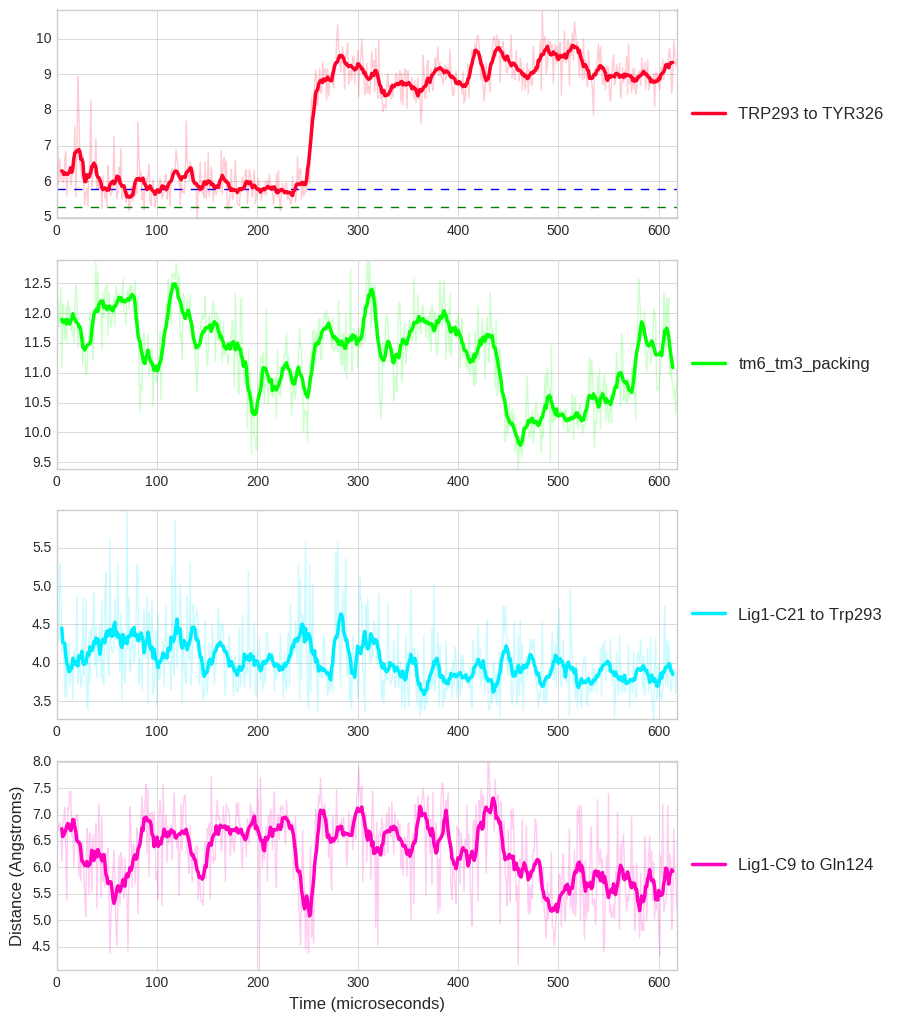

In [135]:
#chosen_features = ["tm6_tm3_packing", "Lig1-C20 to Ile296", "Lig1-C11 to Ile322", "Lig1-C17 to Gly325", "Lig1-C26 to Asn127",
#                   "Lig1-C23 to Gly325", "Lig1-C22 to Tyr326", "Lig1-C17 to Tyr326", "Lig1-C15 to Ile144", "Lig1-C16 to Trp293", "Lig1-C26 to Gln124"]

chosen_features = ["TRP293 to TYR326", "tm6_tm3_packing", "Lig1-C21 to Trp293", "Lig1-C9 to Gln124"]
for tup in [t for t in trajs_to_watch["tm6_tm3_packing"]]:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features[i]
    df = copy.deepcopy(featurized_traj[chosen_features])
    plot_df_rolling(df, "%s/suf_lp-restricted_%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=ref_features)

In [276]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize-py3/analysis_n_clusters1000_random-1000clusters_25lag-time'